In [3]:
import torch
torch.__version__

'2.1.2+cu121'

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [1]:
MODEL_ARCH = 'yolo_nas_l'  # model name
BATCH_SIZE = 16  # how many images the model see at once
MAX_EPOCHS = 100  # max trining epocs : how many times the model see the image
EPOCHS = 100
CHECKPOINT_DIR = r"D:\Final Project\Yolo nas\Dataset\checkpoints"  # output folder path
EXPERIMENT_NAME = "tips and liquid"  # name of our project model

In [3]:
from super_gradients.training import Trainer

# set trainer
trainer = Trainer(experiment_name=EXPERIMENT_NAME,
                  ckpt_root_dir=CHECKPOINT_DIR)

In [4]:
# data params for data dir and path for each folder and the classes

dataset_params = {


    'data_dir': 'D:\Final Project\Yolo nas\Dataset',
    'train_images_dir': 'train\images',
    'train_labels_dir': 'train\labels',


    'val_images_dir': 'valid\images',
    'val_labels_dir': 'valid\labels',
    'test_images_dir': 'test\images',
    'test_labels_dir': 'test\labels',


    'classes': ["Tip", "Liquid"]


}

In [5]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)


In [6]:
# Setting up Training Data Loader
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

[2024-01-20 20:17:31] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 55/55 [00:00<00:00, 113.85it/s]
[2024-01-20 20:17:32] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 10/10 [00:00<00:00, 74.47it/s]
[2024-01-20 20:17:32] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


Indexing dataset annotations: 100%|██████████| 6/6 [00:00<00:00, 65.33it/s]


# Now inspect the dataset defined earlier.

SuperGradients added transforms for you. You're free to experiment with these transformations as you please. You can also add in your own transformations from torchvision.transforms, albumentations or a custom tranformaton.

In [7]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [8]:
# The transforms are in a dictionary, so you'll need to slice it to modify.

train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

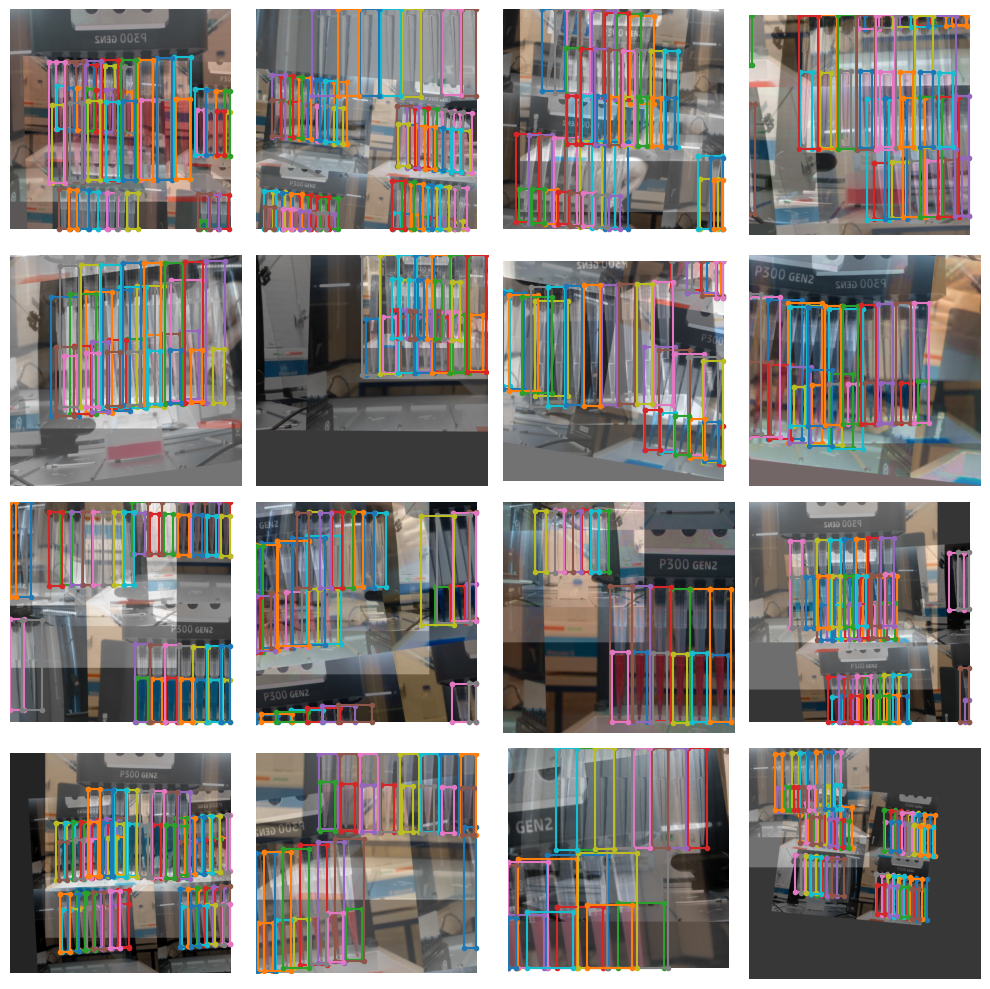

In [9]:
train_data.dataset.plot()

# Setup the model we want to use

In [10]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2024-01-20 20:20:12] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to C:\Users\thisi/.cache\torch\hub\checkpoints\yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:07<00:00, 38.1MB/s] 
[2024-01-20 20:20:21] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [11]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

# Set The Train Params
max_epochs - Max number of training epochs

loss - the loss function you want to use

optimizer - Optimizer you will be using

train_metrics_list - Metrics to log during training

valid_metrics_list - Metrics to log during training

metric_to_watch - metric which the model checkpoint will be saved according to

In [12]:
train_params = {
    # ENABLING SILENT MODE SET True if you want
    'silent_mode': False, #if you want to see the progress bar
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [13]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

[2024-01-20 20:27:48] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240120_202748_124739`
[2024-01-20 20:27:48] INFO - sg_trainer.py - Checkpoints directory: D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739
[2024-01-20 20:27:48] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739/console_Jan20_20_27_48.txt


c:\Users\thisi\anaconda3\envs\OT2\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\Users\thisi\anaconda3\envs\OT2\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-01-20 20:28:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)


SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.6455
│   ├── Ppyoloeloss/loss_iou = 1.3017
│   ├── Ppyoloeloss/loss_dfl = 1.0191
│   └── Ppyoloeloss/loss = 3.9664
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7234
    ├── Ppyoloeloss/loss_iou = 1.2919
    ├── Ppyoloeloss/loss_dfl = 0.9078
    ├── Ppyoloeloss/loss = 3.9232
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 1/1 [00:11<00:00, 11.34s/it]
[2024-01-20 20:29:35] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:29:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.44993698596954346


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.6679
│   │   ├── Epoch N-1      = 1.6455 (↗ 0.0224)
│   │   └── Best until now = 1.6455 (↗ 0.0224)
│   ├── Ppyoloeloss/loss_iou = 1.2781
│   │   ├── Epoch N-1      = 1.3017 (↘ -0.0236)
│   │   └── Best until now = 1.3017 (↘ -0.0236)
│   ├── Ppyoloeloss/loss_dfl = 1.016
│   │   ├── Epoch N-1      = 1.0191 (↘ -0.0031)
│   │   └── Best until now = 1.0191 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 3.9619
│       ├── Epoch N-1      = 3.9664 (↘ -0.0044)
│       └── Best until now = 3.9664 (↘ -0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.2223
    │   ├── Epoch N-1      = 1.7234 (↗ 0.4989)
    │   └── Best until now = 1.7234 (↗ 0.4989)
    ├── Ppyoloeloss/loss_iou = 0.4861
    │   ├── Epoch N-1      = 1.2919 (↘ -0.8059)
    │   └── Best until now = 1.2919 (↘ -0.8059)
    ├── Ppyoloeloss/loss_dfl = 0.5236
    │   ├── Epoch N-1      = 0.9078 (↘ -0.3842)
    │   └── Best until now = 0.9078 (↘ -0.3842)
    ├── Ppyoloeloss/loss = 

Validating epoch 2: 100%|██████████| 1/1 [00:11<00:00, 11.59s/it]
[2024-01-20 20:30:19] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:30:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5302704572677612


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5279
│   │   ├── Epoch N-1      = 1.6679 (↘ -0.14)
│   │   └── Best until now = 1.6455 (↘ -0.1176)
│   ├── Ppyoloeloss/loss_iou = 0.699
│   │   ├── Epoch N-1      = 1.2781 (↘ -0.5791)
│   │   └── Best until now = 1.2781 (↘ -0.5791)
│   ├── Ppyoloeloss/loss_dfl = 0.6272
│   │   ├── Epoch N-1      = 1.016  (↘ -0.3888)
│   │   └── Best until now = 1.016  (↘ -0.3888)
│   └── Ppyoloeloss/loss = 2.8541
│       ├── Epoch N-1      = 3.9619 (↘ -1.1079)
│       └── Best until now = 3.9619 (↘ -1.1079)
└── Validation
    ├── Ppyoloeloss/loss_cls = 31.1335
    │   ├── Epoch N-1      = 2.2223 (↗ 28.9112)
    │   └── Best until now = 1.7234 (↗ 29.4101)
    ├── Ppyoloeloss/loss_iou = 0.5161
    │   ├── Epoch N-1      = 0.4861 (↗ 0.0301)
    │   └── Best until now = 0.4861 (↗ 0.0301)
    ├── Ppyoloeloss/loss_dfl = 0.6286
    │   ├── Epoch N-1      = 0.5236 (↗ 0.105)
    │   └── Best until now = 0.5236 (↗ 0.105)
    ├── Ppyoloeloss/loss = 32.

Validating epoch 3: 100%|██████████| 1/1 [00:11<00:00, 11.57s/it]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9887
│   │   ├── Epoch N-1      = 1.5279 (↘ -0.5392)
│   │   └── Best until now = 1.5279 (↘ -0.5392)
│   ├── Ppyoloeloss/loss_iou = 0.6192
│   │   ├── Epoch N-1      = 0.699  (↘ -0.0799)
│   │   └── Best until now = 0.699  (↘ -0.0799)
│   ├── Ppyoloeloss/loss_dfl = 0.5662
│   │   ├── Epoch N-1      = 0.6272 (↘ -0.0609)
│   │   └── Best until now = 0.6272 (↘ -0.0609)
│   └── Ppyoloeloss/loss = 2.174
│       ├── Epoch N-1      = 2.8541 (↘ -0.68)
│       └── Best until now = 2.8541 (↘ -0.68)
└── Validation
    ├── Ppyoloeloss/loss_cls = 74.9365
    │   ├── Epoch N-1      = 31.1335 (↗ 43.803)
    │   └── Best until now = 1.7234 (↗ 73.213)
    ├── Ppyoloeloss/loss_iou = 0.5774
    │   ├── Epoch N-1      = 0.5161 (↗ 0.0613)
    │   └── Best until now = 0.4861 (↗ 0.0913)
    ├── Ppyoloeloss/loss_dfl = 0.6571
    │   ├── Epoch N-1      = 0.6286 (↗ 0.0285)
    │   └── Best until now = 0.5236 (↗ 0.1335)
    ├── Ppyoloeloss/loss = 76.1

Validating epoch 4: 100%|██████████| 1/1 [00:10<00:00, 10.96s/it]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8674
│   │   ├── Epoch N-1      = 0.9887 (↘ -0.1213)
│   │   └── Best until now = 0.9887 (↘ -0.1213)
│   ├── Ppyoloeloss/loss_iou = 0.5708
│   │   ├── Epoch N-1      = 0.6192 (↘ -0.0483)
│   │   └── Best until now = 0.6192 (↘ -0.0483)
│   ├── Ppyoloeloss/loss_dfl = 0.5239
│   │   ├── Epoch N-1      = 0.5662 (↘ -0.0423)
│   │   └── Best until now = 0.5662 (↘ -0.0423)
│   └── Ppyoloeloss/loss = 1.9621
│       ├── Epoch N-1      = 2.174  (↘ -0.2119)
│       └── Best until now = 2.174  (↘ -0.2119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 150.1592
    │   ├── Epoch N-1      = 74.9365 (↗ 75.2227)
    │   └── Best until now = 1.7234 (↗ 148.4358)
    ├── Ppyoloeloss/loss_iou = 0.6038
    │   ├── Epoch N-1      = 0.5774 (↗ 0.0264)
    │   └── Best until now = 0.4861 (↗ 0.1178)
    ├── Ppyoloeloss/loss_dfl = 0.6605
    │   ├── Epoch N-1      = 0.6571 (↗ 0.0034)
    │   └── Best until now = 0.5236 (↗ 0.1369)
    ├── Ppyoloeloss/lo

Validating epoch 5: 100%|██████████| 1/1 [00:11<00:00, 11.08s/it]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8361
│   │   ├── Epoch N-1      = 0.8674 (↘ -0.0313)
│   │   └── Best until now = 0.8674 (↘ -0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.5688
│   │   ├── Epoch N-1      = 0.5708 (↘ -0.002)
│   │   └── Best until now = 0.5708 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.497
│   │   ├── Epoch N-1      = 0.5239 (↘ -0.0269)
│   │   └── Best until now = 0.5239 (↘ -0.0269)
│   └── Ppyoloeloss/loss = 1.9019
│       ├── Epoch N-1      = 1.9621 (↘ -0.0603)
│       └── Best until now = 1.9621 (↘ -0.0603)
└── Validation
    ├── Ppyoloeloss/loss_cls = 66.0561
    │   ├── Epoch N-1      = 150.1592 (↘ -84.1031)
    │   └── Best until now = 1.7234 (↗ 64.3327)
    ├── Ppyoloeloss/loss_iou = 1.0484
    │   ├── Epoch N-1      = 0.6038 (↗ 0.4446)
    │   └── Best until now = 0.4861 (↗ 0.5623)
    ├── Ppyoloeloss/loss_dfl = 1.1082
    │   ├── Epoch N-1      = 0.6605 (↗ 0.4478)
    │   └── Best until now = 0.5236 (↗ 0.5846)
    ├── Ppyoloeloss/loss 

Validating epoch 6: 100%|██████████| 1/1 [00:11<00:00, 11.03s/it]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8341
│   │   ├── Epoch N-1      = 0.8361 (↘ -0.0019)
│   │   └── Best until now = 0.8361 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.5339
│   │   ├── Epoch N-1      = 0.5688 (↘ -0.0349)
│   │   └── Best until now = 0.5688 (↘ -0.0349)
│   ├── Ppyoloeloss/loss_dfl = 0.4865
│   │   ├── Epoch N-1      = 0.497  (↘ -0.0105)
│   │   └── Best until now = 0.497  (↘ -0.0105)
│   └── Ppyoloeloss/loss = 1.8545
│       ├── Epoch N-1      = 1.9019 (↘ -0.0474)
│       └── Best until now = 1.9019 (↘ -0.0474)
└── Validation
    ├── Ppyoloeloss/loss_cls = 46.5007
    │   ├── Epoch N-1      = 66.0561 (↘ -19.5554)
    │   └── Best until now = 1.7234 (↗ 44.7773)
    ├── Ppyoloeloss/loss_iou = 1.1599
    │   ├── Epoch N-1      = 1.0484 (↗ 0.1115)
    │   └── Best until now = 0.4861 (↗ 0.6738)
    ├── Ppyoloeloss/loss_dfl = 1.307
    │   ├── Epoch N-1      = 1.1082 (↗ 0.1988)
    │   └── Best until now = 0.5236 (↗ 0.7834)
    ├── Ppyoloeloss/loss

Validating epoch 7: 100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8231
│   │   ├── Epoch N-1      = 0.8341 (↘ -0.0111)
│   │   └── Best until now = 0.8341 (↘ -0.0111)
│   ├── Ppyoloeloss/loss_iou = 0.5341
│   │   ├── Epoch N-1      = 0.5339 (↗ 0.0002)
│   │   └── Best until now = 0.5339 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.4908
│   │   ├── Epoch N-1      = 0.4865 (↗ 0.0044)
│   │   └── Best until now = 0.4865 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.848
│       ├── Epoch N-1      = 1.8545 (↘ -0.0065)
│       └── Best until now = 1.8545 (↘ -0.0065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 130.7063
    │   ├── Epoch N-1      = 46.5007 (↗ 84.2056)
    │   └── Best until now = 1.7234 (↗ 128.9829)
    ├── Ppyoloeloss/loss_iou = 1.0421
    │   ├── Epoch N-1      = 1.1599 (↘ -0.1178)
    │   └── Best until now = 0.4861 (↗ 0.556)
    ├── Ppyoloeloss/loss_dfl = 1.133
    │   ├── Epoch N-1      = 1.307  (↘ -0.1741)
    │   └── Best until now = 0.5236 (↗ 0.6093)
    ├── Ppyoloeloss/loss = 

Validating epoch 8: 100%|██████████| 1/1 [00:10<00:00, 10.40s/it]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7826
│   │   ├── Epoch N-1      = 0.8231 (↘ -0.0404)
│   │   └── Best until now = 0.8231 (↘ -0.0404)
│   ├── Ppyoloeloss/loss_iou = 0.4807
│   │   ├── Epoch N-1      = 0.5341 (↘ -0.0534)
│   │   └── Best until now = 0.5339 (↘ -0.0532)
│   ├── Ppyoloeloss/loss_dfl = 0.4577
│   │   ├── Epoch N-1      = 0.4908 (↘ -0.0332)
│   │   └── Best until now = 0.4865 (↘ -0.0288)
│   └── Ppyoloeloss/loss = 1.721
│       ├── Epoch N-1      = 1.848  (↘ -0.127)
│       └── Best until now = 1.848  (↘ -0.127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1036.1613
    │   ├── Epoch N-1      = 130.7063 (↗ 905.455)
    │   └── Best until now = 1.7234 (↗ 1034.4379)
    ├── Ppyoloeloss/loss_iou = 1.0194
    │   ├── Epoch N-1      = 1.0421 (↘ -0.0227)
    │   └── Best until now = 0.4861 (↗ 0.5333)
    ├── Ppyoloeloss/loss_dfl = 1.0194
    │   ├── Epoch N-1      = 1.133  (↘ -0.1135)
    │   └── Best until now = 0.5236 (↗ 0.4958)
    ├── Ppyoloeloss/

Validating epoch 9: 100%|██████████| 1/1 [00:10<00:00, 10.63s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7817
│   │   ├── Epoch N-1      = 0.7826 (↘ -0.0009)
│   │   └── Best until now = 0.7826 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.467
│   │   ├── Epoch N-1      = 0.4807 (↘ -0.0137)
│   │   └── Best until now = 0.4807 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.442
│   │   ├── Epoch N-1      = 0.4577 (↘ -0.0157)
│   │   └── Best until now = 0.4577 (↘ -0.0157)
│   └── Ppyoloeloss/loss = 1.6907
│       ├── Epoch N-1      = 1.721  (↘ -0.0302)
│       └── Best until now = 1.721  (↘ -0.0302)
└── Validation
    ├── Ppyoloeloss/loss_cls = 253.2091
    │   ├── Epoch N-1      = 1036.1613 (↘ -782.9522)
    │   └── Best until now = 1.7234 (↗ 251.4857)
    ├── Ppyoloeloss/loss_iou = 0.8335
    │   ├── Epoch N-1      = 1.0194 (↘ -0.1858)
    │   └── Best until now = 0.4861 (↗ 0.3475)
    ├── Ppyoloeloss/loss_dfl = 0.8543
    │   ├── Epoch N-1      = 1.0194 (↘ -0.1652)
    │   └── Best until now = 0.5236 (↗ 0.3307)
    ├── Ppyoloelos

Validating epoch 10: 100%|██████████| 1/1 [00:10<00:00, 10.69s/it]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7567
│   │   ├── Epoch N-1      = 0.7817 (↘ -0.025)
│   │   └── Best until now = 0.7817 (↘ -0.025)
│   ├── Ppyoloeloss/loss_iou = 0.47
│   │   ├── Epoch N-1      = 0.467  (↗ 0.003)
│   │   └── Best until now = 0.467  (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.4462
│   │   ├── Epoch N-1      = 0.442  (↗ 0.0042)
│   │   └── Best until now = 0.442  (↗ 0.0042)
│   └── Ppyoloeloss/loss = 1.6729
│       ├── Epoch N-1      = 1.6907 (↘ -0.0178)
│       └── Best until now = 1.6907 (↘ -0.0178)
└── Validation
    ├── Ppyoloeloss/loss_cls = 10.0071
    │   ├── Epoch N-1      = 253.2091 (↘ -243.2021)
    │   └── Best until now = 1.7234 (↗ 8.2836)
    ├── Ppyoloeloss/loss_iou = 0.7382
    │   ├── Epoch N-1      = 0.8335 (↘ -0.0954)
    │   └── Best until now = 0.4861 (↗ 0.2521)
    ├── Ppyoloeloss/loss_dfl = 0.743
    │   ├── Epoch N-1      = 0.8543 (↘ -0.1113)
    │   └── Best until now = 0.5236 (↗ 0.2194)
    ├── Ppyoloeloss/loss = 11.

Validating epoch 11: 100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7411
│   │   ├── Epoch N-1      = 0.7567 (↘ -0.0156)
│   │   └── Best until now = 0.7567 (↘ -0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.426
│   │   ├── Epoch N-1      = 0.47   (↘ -0.044)
│   │   └── Best until now = 0.467  (↘ -0.041)
│   ├── Ppyoloeloss/loss_dfl = 0.4274
│   │   ├── Epoch N-1      = 0.4462 (↘ -0.0188)
│   │   └── Best until now = 0.442  (↘ -0.0146)
│   └── Ppyoloeloss/loss = 1.5945
│       ├── Epoch N-1      = 1.6729 (↘ -0.0784)
│       └── Best until now = 1.6729 (↘ -0.0784)
└── Validation
    ├── Ppyoloeloss/loss_cls = 5.8881
    │   ├── Epoch N-1      = 10.0071 (↘ -4.119)
    │   └── Best until now = 1.7234 (↗ 4.1646)
    ├── Ppyoloeloss/loss_iou = 0.5501
    │   ├── Epoch N-1      = 0.7382 (↘ -0.1881)
    │   └── Best until now = 0.4861 (↗ 0.064)
    ├── Ppyoloeloss/loss_dfl = 0.5761
    │   ├── Epoch N-1      = 0.743  (↘ -0.1669)
    │   └── Best until now = 0.5236 (↗ 0.0525)
    ├── Ppyoloeloss/loss = 7

Validating epoch 12: 100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7171
│   │   ├── Epoch N-1      = 0.7411 (↘ -0.0241)
│   │   └── Best until now = 0.7411 (↘ -0.0241)
│   ├── Ppyoloeloss/loss_iou = 0.4276
│   │   ├── Epoch N-1      = 0.426  (↗ 0.0016)
│   │   └── Best until now = 0.426  (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.4129
│   │   ├── Epoch N-1      = 0.4274 (↘ -0.0145)
│   │   └── Best until now = 0.4274 (↘ -0.0145)
│   └── Ppyoloeloss/loss = 1.5576
│       ├── Epoch N-1      = 1.5945 (↘ -0.0369)
│       └── Best until now = 1.5945 (↘ -0.0369)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.8478
    │   ├── Epoch N-1      = 5.8881 (↘ -3.0403)
    │   └── Best until now = 1.7234 (↗ 1.1244)
    ├── Ppyoloeloss/loss_iou = 0.4478
    │   ├── Epoch N-1      = 0.5501 (↘ -0.1023)
    │   └── Best until now = 0.4861 (↘ -0.0382)
    ├── Ppyoloeloss/loss_dfl = 0.5134
    │   ├── Epoch N-1      = 0.5761 (↘ -0.0627)
    │   └── Best until now = 0.5236 (↘ -0.0102)
    ├── Ppyoloeloss/loss

Validating epoch 13: 100%|██████████| 1/1 [00:10<00:00, 10.49s/it]
[2024-01-20 20:38:40] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:38:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8149486780166626


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.728
│   │   ├── Epoch N-1      = 0.7171 (↗ 0.0109)
│   │   └── Best until now = 0.7171 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.4041
│   │   ├── Epoch N-1      = 0.4276 (↘ -0.0236)
│   │   └── Best until now = 0.426  (↘ -0.022)
│   ├── Ppyoloeloss/loss_dfl = 0.422
│   │   ├── Epoch N-1      = 0.4129 (↗ 0.0091)
│   │   └── Best until now = 0.4129 (↗ 0.0091)
│   └── Ppyoloeloss/loss = 1.554
│       ├── Epoch N-1      = 1.5576 (↘ -0.0036)
│       └── Best until now = 1.5576 (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5902
    │   ├── Epoch N-1      = 2.8478 (↘ -1.2576)
    │   └── Best until now = 1.7234 (↘ -0.1332)
    ├── Ppyoloeloss/loss_iou = 0.4135
    │   ├── Epoch N-1      = 0.4478 (↘ -0.0344)
    │   └── Best until now = 0.4478 (↘ -0.0344)
    ├── Ppyoloeloss/loss_dfl = 0.466
    │   ├── Epoch N-1      = 0.5134 (↘ -0.0474)
    │   └── Best until now = 0.5134 (↘ -0.0474)
    ├── Ppyoloeloss/loss = 2.4

Validating epoch 14: 100%|██████████| 1/1 [00:10<00:00, 10.54s/it]
[2024-01-20 20:39:27] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:39:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9429221153259277


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7222
│   │   ├── Epoch N-1      = 0.728  (↘ -0.0058)
│   │   └── Best until now = 0.7171 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.4276
│   │   ├── Epoch N-1      = 0.4041 (↗ 0.0236)
│   │   └── Best until now = 0.4041 (↗ 0.0236)
│   ├── Ppyoloeloss/loss_dfl = 0.4187
│   │   ├── Epoch N-1      = 0.422  (↘ -0.0033)
│   │   └── Best until now = 0.4129 (↗ 0.0058)
│   └── Ppyoloeloss/loss = 1.5686
│       ├── Epoch N-1      = 1.554  (↗ 0.0145)
│       └── Best until now = 1.554  (↗ 0.0145)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.895
    │   ├── Epoch N-1      = 1.5902 (↘ -0.6952)
    │   └── Best until now = 1.5902 (↘ -0.6952)
    ├── Ppyoloeloss/loss_iou = 0.3423
    │   ├── Epoch N-1      = 0.4135 (↘ -0.0712)
    │   └── Best until now = 0.4135 (↘ -0.0712)
    ├── Ppyoloeloss/loss_dfl = 0.4111
    │   ├── Epoch N-1      = 0.466  (↘ -0.0549)
    │   └── Best until now = 0.466  (↘ -0.0549)
    ├── Ppyoloeloss/loss = 1

Validating epoch 15: 100%|██████████| 1/1 [00:10<00:00, 10.52s/it]
[2024-01-20 20:40:16] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:40:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9563114047050476


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7079
│   │   ├── Epoch N-1      = 0.7222 (↘ -0.0143)
│   │   └── Best until now = 0.7171 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.4129
│   │   ├── Epoch N-1      = 0.4276 (↘ -0.0147)
│   │   └── Best until now = 0.4041 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.412
│   │   ├── Epoch N-1      = 0.4187 (↘ -0.0067)
│   │   └── Best until now = 0.4129 (↘ -0.0009)
│   └── Ppyoloeloss/loss = 1.5329
│       ├── Epoch N-1      = 1.5686 (↘ -0.0357)
│       └── Best until now = 1.554  (↘ -0.0212)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7385
    │   ├── Epoch N-1      = 0.895  (↘ -0.1566)
    │   └── Best until now = 0.895  (↘ -0.1566)
    ├── Ppyoloeloss/loss_iou = 0.3306
    │   ├── Epoch N-1      = 0.3423 (↘ -0.0116)
    │   └── Best until now = 0.3423 (↘ -0.0116)
    ├── Ppyoloeloss/loss_dfl = 0.3958
    │   ├── Epoch N-1      = 0.4111 (↘ -0.0153)
    │   └── Best until now = 0.4111 (↘ -0.0153)
    ├── Ppyoloeloss/los

Validating epoch 16: 100%|██████████| 1/1 [00:10<00:00, 10.46s/it]
[2024-01-20 20:41:04] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:41:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.960648775100708


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7021
│   │   ├── Epoch N-1      = 0.7079 (↘ -0.0058)
│   │   └── Best until now = 0.7079 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.3937
│   │   ├── Epoch N-1      = 0.4129 (↘ -0.0192)
│   │   └── Best until now = 0.4041 (↘ -0.0103)
│   ├── Ppyoloeloss/loss_dfl = 0.3999
│   │   ├── Epoch N-1      = 0.412  (↘ -0.0121)
│   │   └── Best until now = 0.412  (↘ -0.0121)
│   └── Ppyoloeloss/loss = 1.4957
│       ├── Epoch N-1      = 1.5329 (↘ -0.0371)
│       └── Best until now = 1.5329 (↘ -0.0371)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7125
    │   ├── Epoch N-1      = 0.7385 (↘ -0.0259)
    │   └── Best until now = 0.7385 (↘ -0.0259)
    ├── Ppyoloeloss/loss_iou = 0.2969
    │   ├── Epoch N-1      = 0.3306 (↘ -0.0337)
    │   └── Best until now = 0.3306 (↘ -0.0337)
    ├── Ppyoloeloss/loss_dfl = 0.3682
    │   ├── Epoch N-1      = 0.3958 (↘ -0.0276)
    │   └── Best until now = 0.3958 (↘ -0.0276)
    ├── Ppyoloeloss/l

Validating epoch 17: 100%|██████████| 1/1 [00:10<00:00, 10.73s/it]
[2024-01-20 20:41:53] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:41:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9680594205856323


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7049
│   │   ├── Epoch N-1      = 0.7021 (↗ 0.0028)
│   │   └── Best until now = 0.7021 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.4049
│   │   ├── Epoch N-1      = 0.3937 (↗ 0.0112)
│   │   └── Best until now = 0.3937 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.4062
│   │   ├── Epoch N-1      = 0.3999 (↗ 0.0064)
│   │   └── Best until now = 0.3999 (↗ 0.0064)
│   └── Ppyoloeloss/loss = 1.5161
│       ├── Epoch N-1      = 1.4957 (↗ 0.0204)
│       └── Best until now = 1.4957 (↗ 0.0204)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7037
    │   ├── Epoch N-1      = 0.7125 (↘ -0.0088)
    │   └── Best until now = 0.7125 (↘ -0.0088)
    ├── Ppyoloeloss/loss_iou = 0.2788
    │   ├── Epoch N-1      = 0.2969 (↘ -0.0181)
    │   └── Best until now = 0.2969 (↘ -0.0181)
    ├── Ppyoloeloss/loss_dfl = 0.3572
    │   ├── Epoch N-1      = 0.3682 (↘ -0.011)
    │   └── Best until now = 0.3682 (↘ -0.011)
    ├── Ppyoloeloss/loss = 1.33

Validating epoch 18: 100%|██████████| 1/1 [00:10<00:00, 10.44s/it]
[2024-01-20 20:42:41] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 20:42:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9696428775787354


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6963
│   │   ├── Epoch N-1      = 0.7049 (↘ -0.0086)
│   │   └── Best until now = 0.7021 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.3917
│   │   ├── Epoch N-1      = 0.4049 (↘ -0.0132)
│   │   └── Best until now = 0.3937 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3966
│   │   ├── Epoch N-1      = 0.4062 (↘ -0.0097)
│   │   └── Best until now = 0.3999 (↘ -0.0033)
│   └── Ppyoloeloss/loss = 1.4847
│       ├── Epoch N-1      = 1.5161 (↘ -0.0314)
│       └── Best until now = 1.4957 (↘ -0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6716
    │   ├── Epoch N-1      = 0.7037 (↘ -0.0322)
    │   └── Best until now = 0.7037 (↘ -0.0322)
    ├── Ppyoloeloss/loss_iou = 0.2744
    │   ├── Epoch N-1      = 0.2788 (↘ -0.0045)
    │   └── Best until now = 0.2788 (↘ -0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.3516
    │   ├── Epoch N-1      = 0.3572 (↘ -0.0057)
    │   └── Best until now = 0.3572 (↘ -0.0057)
    ├── Ppyoloeloss/lo

Validating epoch 19: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6848
│   │   ├── Epoch N-1      = 0.6963 (↘ -0.0116)
│   │   └── Best until now = 0.6963 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_iou = 0.3727
│   │   ├── Epoch N-1      = 0.3917 (↘ -0.019)
│   │   └── Best until now = 0.3917 (↘ -0.019)
│   ├── Ppyoloeloss/loss_dfl = 0.3865
│   │   ├── Epoch N-1      = 0.3966 (↘ -0.01)
│   │   └── Best until now = 0.3966 (↘ -0.01)
│   └── Ppyoloeloss/loss = 1.444
│       ├── Epoch N-1      = 1.4847 (↘ -0.0407)
│       └── Best until now = 1.4847 (↘ -0.0407)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6303
    │   ├── Epoch N-1      = 0.6716 (↘ -0.0412)
    │   └── Best until now = 0.6716 (↘ -0.0412)
    ├── Ppyoloeloss/loss_iou = 0.265
    │   ├── Epoch N-1      = 0.2744 (↘ -0.0094)
    │   └── Best until now = 0.2744 (↘ -0.0094)
    ├── Ppyoloeloss/loss_dfl = 0.3447
    │   ├── Epoch N-1      = 0.3516 (↘ -0.0069)
    │   └── Best until now = 0.3516 (↘ -0.0069)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 20: 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6686
│   │   ├── Epoch N-1      = 0.6848 (↘ -0.0162)
│   │   └── Best until now = 0.6848 (↘ -0.0162)
│   ├── Ppyoloeloss/loss_iou = 0.3721
│   │   ├── Epoch N-1      = 0.3727 (↘ -0.0006)
│   │   └── Best until now = 0.3727 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.3826
│   │   ├── Epoch N-1      = 0.3865 (↘ -0.0039)
│   │   └── Best until now = 0.3865 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.4232
│       ├── Epoch N-1      = 1.444  (↘ -0.0208)
│       └── Best until now = 1.444  (↘ -0.0208)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6134
    │   ├── Epoch N-1      = 0.6303 (↘ -0.0169)
    │   └── Best until now = 0.6303 (↘ -0.0169)
    ├── Ppyoloeloss/loss_iou = 0.2667
    │   ├── Epoch N-1      = 0.265  (↗ 0.0017)
    │   └── Best until now = 0.265  (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.336
    │   ├── Epoch N-1      = 0.3447 (↘ -0.0087)
    │   └── Best until now = 0.3447 (↘ -0.0087)
    ├── Ppyoloeloss/loss

Validating epoch 21: 100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6855
│   │   ├── Epoch N-1      = 0.6686 (↗ 0.0169)
│   │   └── Best until now = 0.6686 (↗ 0.0169)
│   ├── Ppyoloeloss/loss_iou = 0.3866
│   │   ├── Epoch N-1      = 0.3721 (↗ 0.0145)
│   │   └── Best until now = 0.3721 (↗ 0.0145)
│   ├── Ppyoloeloss/loss_dfl = 0.4044
│   │   ├── Epoch N-1      = 0.3826 (↗ 0.0219)
│   │   └── Best until now = 0.3826 (↗ 0.0219)
│   └── Ppyoloeloss/loss = 1.4766
│       ├── Epoch N-1      = 1.4232 (↗ 0.0533)
│       └── Best until now = 1.4232 (↗ 0.0533)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5919
    │   ├── Epoch N-1      = 0.6134 (↘ -0.0215)
    │   └── Best until now = 0.6134 (↘ -0.0215)
    ├── Ppyoloeloss/loss_iou = 0.2491
    │   ├── Epoch N-1      = 0.2667 (↘ -0.0176)
    │   └── Best until now = 0.265  (↘ -0.0159)
    ├── Ppyoloeloss/loss_dfl = 0.3212
    │   ├── Epoch N-1      = 0.336  (↘ -0.0148)
    │   └── Best until now = 0.336  (↘ -0.0148)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 22: 100%|██████████| 1/1 [00:10<00:00, 10.67s/it]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6671
│   │   ├── Epoch N-1      = 0.6855 (↘ -0.0184)
│   │   └── Best until now = 0.6686 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.3695
│   │   ├── Epoch N-1      = 0.3866 (↘ -0.0171)
│   │   └── Best until now = 0.3721 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.3766
│   │   ├── Epoch N-1      = 0.4044 (↘ -0.0278)
│   │   └── Best until now = 0.3826 (↘ -0.006)
│   └── Ppyoloeloss/loss = 1.4133
│       ├── Epoch N-1      = 1.4766 (↘ -0.0633)
│       └── Best until now = 1.4232 (↘ -0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6079
    │   ├── Epoch N-1      = 0.5919 (↗ 0.016)
    │   └── Best until now = 0.5919 (↗ 0.016)
    ├── Ppyoloeloss/loss_iou = 0.2529
    │   ├── Epoch N-1      = 0.2491 (↗ 0.0038)
    │   └── Best until now = 0.2491 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.3241
    │   ├── Epoch N-1      = 0.3212 (↗ 0.0029)
    │   └── Best until now = 0.3212 (↗ 0.0029)
    ├── Ppyoloeloss/loss = 1.184

Validating epoch 23: 100%|██████████| 1/1 [00:10<00:00, 10.28s/it]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6532
│   │   ├── Epoch N-1      = 0.6671 (↘ -0.0139)
│   │   └── Best until now = 0.6671 (↘ -0.0139)
│   ├── Ppyoloeloss/loss_iou = 0.3662
│   │   ├── Epoch N-1      = 0.3695 (↘ -0.0034)
│   │   └── Best until now = 0.3695 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.3744
│   │   ├── Epoch N-1      = 0.3766 (↘ -0.0022)
│   │   └── Best until now = 0.3766 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.3937
│       ├── Epoch N-1      = 1.4133 (↘ -0.0195)
│       └── Best until now = 1.4133 (↘ -0.0195)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6047
    │   ├── Epoch N-1      = 0.6079 (↘ -0.0032)
    │   └── Best until now = 0.5919 (↗ 0.0128)
    ├── Ppyoloeloss/loss_iou = 0.249
    │   ├── Epoch N-1      = 0.2529 (↘ -0.0039)
    │   └── Best until now = 0.2491 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.3249
    │   ├── Epoch N-1      = 0.3241 (↗ 0.0008)
    │   └── Best until now = 0.3212 (↗ 0.0037)
    ├── Ppyoloeloss/loss =

Validating epoch 24: 100%|██████████| 1/1 [00:10<00:00, 10.72s/it]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6712
│   │   ├── Epoch N-1      = 0.6532 (↗ 0.018)
│   │   └── Best until now = 0.6532 (↗ 0.018)
│   ├── Ppyoloeloss/loss_iou = 0.3815
│   │   ├── Epoch N-1      = 0.3662 (↗ 0.0153)
│   │   └── Best until now = 0.3662 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_dfl = 0.3914
│   │   ├── Epoch N-1      = 0.3744 (↗ 0.0171)
│   │   └── Best until now = 0.3744 (↗ 0.0171)
│   └── Ppyoloeloss/loss = 1.4441
│       ├── Epoch N-1      = 1.3937 (↗ 0.0504)
│       └── Best until now = 1.3937 (↗ 0.0504)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6176
    │   ├── Epoch N-1      = 0.6047 (↗ 0.0129)
    │   └── Best until now = 0.5919 (↗ 0.0256)
    ├── Ppyoloeloss/loss_iou = 0.2462
    │   ├── Epoch N-1      = 0.249  (↘ -0.0028)
    │   └── Best until now = 0.249  (↘ -0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.3272
    │   ├── Epoch N-1      = 0.3249 (↗ 0.0023)
    │   └── Best until now = 0.3212 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.1909
  

Validating epoch 25: 100%|██████████| 1/1 [00:10<00:00, 10.47s/it]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6842
│   │   ├── Epoch N-1      = 0.6712 (↗ 0.013)
│   │   └── Best until now = 0.6532 (↗ 0.031)
│   ├── Ppyoloeloss/loss_iou = 0.384
│   │   ├── Epoch N-1      = 0.3815 (↗ 0.0025)
│   │   └── Best until now = 0.3662 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_dfl = 0.389
│   │   ├── Epoch N-1      = 0.3914 (↘ -0.0025)
│   │   └── Best until now = 0.3744 (↗ 0.0146)
│   └── Ppyoloeloss/loss = 1.4572
│       ├── Epoch N-1      = 1.4441 (↗ 0.0131)
│       └── Best until now = 1.3937 (↗ 0.0635)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.626
    │   ├── Epoch N-1      = 0.6176 (↗ 0.0085)
    │   └── Best until now = 0.5919 (↗ 0.0341)
    ├── Ppyoloeloss/loss_iou = 0.264
    │   ├── Epoch N-1      = 0.2462 (↗ 0.0178)
    │   └── Best until now = 0.2462 (↗ 0.0178)
    ├── Ppyoloeloss/loss_dfl = 0.3305
    │   ├── Epoch N-1      = 0.3272 (↗ 0.0033)
    │   └── Best until now = 0.3212 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.2205
    │ 

Validating epoch 26: 100%|██████████| 1/1 [00:10<00:00, 10.68s/it]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6659
│   │   ├── Epoch N-1      = 0.6842 (↘ -0.0183)
│   │   └── Best until now = 0.6532 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_iou = 0.3497
│   │   ├── Epoch N-1      = 0.384  (↘ -0.0343)
│   │   └── Best until now = 0.3662 (↘ -0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.3765
│   │   ├── Epoch N-1      = 0.389  (↘ -0.0124)
│   │   └── Best until now = 0.3744 (↗ 0.0022)
│   └── Ppyoloeloss/loss = 1.3921
│       ├── Epoch N-1      = 1.4572 (↘ -0.0651)
│       └── Best until now = 1.3937 (↘ -0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6099
    │   ├── Epoch N-1      = 0.626  (↘ -0.0162)
    │   └── Best until now = 0.5919 (↗ 0.018)
    ├── Ppyoloeloss/loss_iou = 0.2598
    │   ├── Epoch N-1      = 0.264  (↘ -0.0041)
    │   └── Best until now = 0.2462 (↗ 0.0137)
    ├── Ppyoloeloss/loss_dfl = 0.3258
    │   ├── Epoch N-1      = 0.3305 (↘ -0.0047)
    │   └── Best until now = 0.3212 (↗ 0.0046)
    ├── Ppyoloeloss/loss = 

Validating epoch 27: 100%|██████████| 1/1 [00:10<00:00, 10.37s/it]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6637
│   │   ├── Epoch N-1      = 0.6659 (↘ -0.0022)
│   │   └── Best until now = 0.6532 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.3702
│   │   ├── Epoch N-1      = 0.3497 (↗ 0.0205)
│   │   └── Best until now = 0.3497 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.3806
│   │   ├── Epoch N-1      = 0.3765 (↗ 0.0041)
│   │   └── Best until now = 0.3744 (↗ 0.0063)
│   └── Ppyoloeloss/loss = 1.4146
│       ├── Epoch N-1      = 1.3921 (↗ 0.0224)
│       └── Best until now = 1.3921 (↗ 0.0224)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5984
    │   ├── Epoch N-1      = 0.6099 (↘ -0.0115)
    │   └── Best until now = 0.5919 (↗ 0.0065)
    ├── Ppyoloeloss/loss_iou = 0.2527
    │   ├── Epoch N-1      = 0.2598 (↘ -0.0072)
    │   └── Best until now = 0.2462 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.3213
    │   ├── Epoch N-1      = 0.3258 (↘ -0.0045)
    │   └── Best until now = 0.3212 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.172

Validating epoch 28: 100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6614
│   │   ├── Epoch N-1      = 0.6637 (↘ -0.0023)
│   │   └── Best until now = 0.6532 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.3479
│   │   ├── Epoch N-1      = 0.3702 (↘ -0.0223)
│   │   └── Best until now = 0.3497 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3866
│   │   ├── Epoch N-1      = 0.3806 (↗ 0.006)
│   │   └── Best until now = 0.3744 (↗ 0.0122)
│   └── Ppyoloeloss/loss = 1.3959
│       ├── Epoch N-1      = 1.4146 (↘ -0.0187)
│       └── Best until now = 1.3921 (↗ 0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5933
    │   ├── Epoch N-1      = 0.5984 (↘ -0.0052)
    │   └── Best until now = 0.5919 (↗ 0.0013)
    ├── Ppyoloeloss/loss_iou = 0.2489
    │   ├── Epoch N-1      = 0.2527 (↘ -0.0038)
    │   └── Best until now = 0.2462 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.3202
    │   ├── Epoch N-1      = 0.3213 (↘ -0.001)
    │   └── Best until now = 0.3212 (↘ -0.0009)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 29: 100%|██████████| 1/1 [00:10<00:00, 10.66s/it]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6436
│   │   ├── Epoch N-1      = 0.6614 (↘ -0.0178)
│   │   └── Best until now = 0.6532 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.36
│   │   ├── Epoch N-1      = 0.3479 (↗ 0.0121)
│   │   └── Best until now = 0.3479 (↗ 0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.3781
│   │   ├── Epoch N-1      = 0.3866 (↘ -0.0085)
│   │   └── Best until now = 0.3744 (↗ 0.0037)
│   └── Ppyoloeloss/loss = 1.3816
│       ├── Epoch N-1      = 1.3959 (↘ -0.0143)
│       └── Best until now = 1.3921 (↘ -0.0105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5793
    │   ├── Epoch N-1      = 0.5933 (↘ -0.014)
    │   └── Best until now = 0.5919 (↘ -0.0126)
    ├── Ppyoloeloss/loss_iou = 0.2404
    │   ├── Epoch N-1      = 0.2489 (↘ -0.0085)
    │   └── Best until now = 0.2462 (↘ -0.0058)
    ├── Ppyoloeloss/loss_dfl = 0.3147
    │   ├── Epoch N-1      = 0.3202 (↘ -0.0056)
    │   └── Best until now = 0.3202 (↘ -0.0056)
    ├── Ppyoloeloss/loss = 

Validating epoch 30: 100%|██████████| 1/1 [00:10<00:00, 10.02s/it]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6529
│   │   ├── Epoch N-1      = 0.6436 (↗ 0.0093)
│   │   └── Best until now = 0.6436 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.3588
│   │   ├── Epoch N-1      = 0.36   (↘ -0.0012)
│   │   └── Best until now = 0.3479 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_dfl = 0.3791
│   │   ├── Epoch N-1      = 0.3781 (↗ 0.001)
│   │   └── Best until now = 0.3744 (↗ 0.0047)
│   └── Ppyoloeloss/loss = 1.3908
│       ├── Epoch N-1      = 1.3816 (↗ 0.0092)
│       └── Best until now = 1.3816 (↗ 0.0092)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5739
    │   ├── Epoch N-1      = 0.5793 (↘ -0.0053)
    │   └── Best until now = 0.5793 (↘ -0.0053)
    ├── Ppyoloeloss/loss_iou = 0.2391
    │   ├── Epoch N-1      = 0.2404 (↘ -0.0013)
    │   └── Best until now = 0.2404 (↘ -0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.3137
    │   ├── Epoch N-1      = 0.3147 (↘ -0.001)
    │   └── Best until now = 0.3147 (↘ -0.001)
    ├── Ppyoloeloss/loss = 1.12

Validating epoch 31: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6654
│   │   ├── Epoch N-1      = 0.6529 (↗ 0.0124)
│   │   └── Best until now = 0.6436 (↗ 0.0218)
│   ├── Ppyoloeloss/loss_iou = 0.3785
│   │   ├── Epoch N-1      = 0.3588 (↗ 0.0197)
│   │   └── Best until now = 0.3479 (↗ 0.0306)
│   ├── Ppyoloeloss/loss_dfl = 0.3914
│   │   ├── Epoch N-1      = 0.3791 (↗ 0.0123)
│   │   └── Best until now = 0.3744 (↗ 0.017)
│   └── Ppyoloeloss/loss = 1.4352
│       ├── Epoch N-1      = 1.3908 (↗ 0.0445)
│       └── Best until now = 1.3816 (↗ 0.0536)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5708
    │   ├── Epoch N-1      = 0.5739 (↘ -0.0031)
    │   └── Best until now = 0.5739 (↘ -0.0031)
    ├── Ppyoloeloss/loss_iou = 0.233
    │   ├── Epoch N-1      = 0.2391 (↘ -0.0062)
    │   └── Best until now = 0.2391 (↘ -0.0062)
    ├── Ppyoloeloss/loss_dfl = 0.3116
    │   ├── Epoch N-1      = 0.3137 (↘ -0.0021)
    │   └── Best until now = 0.3137 (↘ -0.0021)
    ├── Ppyoloeloss/loss = 1.11

Validating epoch 32: 100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6473
│   │   ├── Epoch N-1      = 0.6654 (↘ -0.0181)
│   │   └── Best until now = 0.6436 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.3454
│   │   ├── Epoch N-1      = 0.3785 (↘ -0.033)
│   │   └── Best until now = 0.3479 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.3731
│   │   ├── Epoch N-1      = 0.3914 (↘ -0.0183)
│   │   └── Best until now = 0.3744 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.3659
│       ├── Epoch N-1      = 1.4352 (↘ -0.0694)
│       └── Best until now = 1.3816 (↘ -0.0158)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5766
    │   ├── Epoch N-1      = 0.5708 (↗ 0.0057)
    │   └── Best until now = 0.5708 (↗ 0.0057)
    ├── Ppyoloeloss/loss_iou = 0.2343
    │   ├── Epoch N-1      = 0.233  (↗ 0.0013)
    │   └── Best until now = 0.233  (↗ 0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.3123
    │   ├── Epoch N-1      = 0.3116 (↗ 0.0007)
    │   └── Best until now = 0.3116 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 33: 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6587
│   │   ├── Epoch N-1      = 0.6473 (↗ 0.0114)
│   │   └── Best until now = 0.6436 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_iou = 0.3659
│   │   ├── Epoch N-1      = 0.3454 (↗ 0.0205)
│   │   └── Best until now = 0.3454 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.3816
│   │   ├── Epoch N-1      = 0.3731 (↗ 0.0085)
│   │   └── Best until now = 0.3731 (↗ 0.0085)
│   └── Ppyoloeloss/loss = 1.4062
│       ├── Epoch N-1      = 1.3659 (↗ 0.0403)
│       └── Best until now = 1.3659 (↗ 0.0403)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5656
    │   ├── Epoch N-1      = 0.5766 (↘ -0.011)
    │   └── Best until now = 0.5708 (↘ -0.0053)
    ├── Ppyoloeloss/loss_iou = 0.2219
    │   ├── Epoch N-1      = 0.2343 (↘ -0.0124)
    │   └── Best until now = 0.233  (↘ -0.0111)
    ├── Ppyoloeloss/loss_dfl = 0.3084
    │   ├── Epoch N-1      = 0.3123 (↘ -0.0039)
    │   └── Best until now = 0.3116 (↘ -0.0032)
    ├── Ppyoloeloss/loss = 1.0

Validating epoch 34: 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6489
│   │   ├── Epoch N-1      = 0.6587 (↘ -0.0098)
│   │   └── Best until now = 0.6436 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.3602
│   │   ├── Epoch N-1      = 0.3659 (↘ -0.0057)
│   │   └── Best until now = 0.3454 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.3686
│   │   ├── Epoch N-1      = 0.3816 (↘ -0.013)
│   │   └── Best until now = 0.3731 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.3776
│       ├── Epoch N-1      = 1.4062 (↘ -0.0286)
│       └── Best until now = 1.3659 (↗ 0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5619
    │   ├── Epoch N-1      = 0.5656 (↘ -0.0037)
    │   └── Best until now = 0.5656 (↘ -0.0037)
    ├── Ppyoloeloss/loss_iou = 0.2124
    │   ├── Epoch N-1      = 0.2219 (↘ -0.0095)
    │   └── Best until now = 0.2219 (↘ -0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.3043
    │   ├── Epoch N-1      = 0.3084 (↘ -0.004)
    │   └── Best until now = 0.3084 (↘ -0.004)
    ├── Ppyoloeloss/loss = 

Validating epoch 35: 100%|██████████| 1/1 [00:10<00:00, 10.21s/it]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6352
│   │   ├── Epoch N-1      = 0.6489 (↘ -0.0136)
│   │   └── Best until now = 0.6436 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.3514
│   │   ├── Epoch N-1      = 0.3602 (↘ -0.0088)
│   │   └── Best until now = 0.3454 (↗ 0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.38
│   │   ├── Epoch N-1      = 0.3686 (↗ 0.0114)
│   │   └── Best until now = 0.3686 (↗ 0.0114)
│   └── Ppyoloeloss/loss = 1.3667
│       ├── Epoch N-1      = 1.3776 (↘ -0.011)
│       └── Best until now = 1.3659 (↗ 0.0008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5729
    │   ├── Epoch N-1      = 0.5619 (↗ 0.011)
    │   └── Best until now = 0.5619 (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.216
    │   ├── Epoch N-1      = 0.2124 (↗ 0.0035)
    │   └── Best until now = 0.2124 (↗ 0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.3082
    │   ├── Epoch N-1      = 0.3043 (↗ 0.0039)
    │   └── Best until now = 0.3043 (↗ 0.0039)
    ├── Ppyoloeloss/loss = 1.0971
    

Validating epoch 36: 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6412
│   │   ├── Epoch N-1      = 0.6352 (↗ 0.006)
│   │   └── Best until now = 0.6352 (↗ 0.006)
│   ├── Ppyoloeloss/loss_iou = 0.3479
│   │   ├── Epoch N-1      = 0.3514 (↘ -0.0035)
│   │   └── Best until now = 0.3454 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.3941
│   │   ├── Epoch N-1      = 0.38   (↗ 0.0141)
│   │   └── Best until now = 0.3686 (↗ 0.0256)
│   └── Ppyoloeloss/loss = 1.3833
│       ├── Epoch N-1      = 1.3667 (↗ 0.0166)
│       └── Best until now = 1.3659 (↗ 0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5809
    │   ├── Epoch N-1      = 0.5729 (↗ 0.008)
    │   └── Best until now = 0.5619 (↗ 0.019)
    ├── Ppyoloeloss/loss_iou = 0.2132
    │   ├── Epoch N-1      = 0.216  (↘ -0.0027)
    │   └── Best until now = 0.2124 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.3033
    │   ├── Epoch N-1      = 0.3082 (↘ -0.0049)
    │   └── Best until now = 0.3043 (↘ -0.001)
    ├── Ppyoloeloss/loss = 1.0974
  

Validating epoch 37: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6531
│   │   ├── Epoch N-1      = 0.6412 (↗ 0.0118)
│   │   └── Best until now = 0.6352 (↗ 0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.3616
│   │   ├── Epoch N-1      = 0.3479 (↗ 0.0136)
│   │   └── Best until now = 0.3454 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_dfl = 0.3847
│   │   ├── Epoch N-1      = 0.3941 (↘ -0.0094)
│   │   └── Best until now = 0.3686 (↗ 0.0161)
│   └── Ppyoloeloss/loss = 1.3993
│       ├── Epoch N-1      = 1.3833 (↗ 0.016)
│       └── Best until now = 1.3659 (↗ 0.0334)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5926
    │   ├── Epoch N-1      = 0.5809 (↗ 0.0117)
    │   └── Best until now = 0.5619 (↗ 0.0307)
    ├── Ppyoloeloss/loss_iou = 0.2114
    │   ├── Epoch N-1      = 0.2132 (↘ -0.0018)
    │   └── Best until now = 0.2124 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.3032
    │   ├── Epoch N-1      = 0.3033 (↘ -1e-04)
    │   └── Best until now = 0.3033 (↘ -1e-04)
    ├── Ppyoloeloss/loss = 1.1073


Validating epoch 38: 100%|██████████| 1/1 [00:10<00:00, 10.53s/it]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6282
│   │   ├── Epoch N-1      = 0.6531 (↘ -0.0249)
│   │   └── Best until now = 0.6352 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.3336
│   │   ├── Epoch N-1      = 0.3616 (↘ -0.028)
│   │   └── Best until now = 0.3454 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_dfl = 0.3615
│   │   ├── Epoch N-1      = 0.3847 (↘ -0.0231)
│   │   └── Best until now = 0.3686 (↘ -0.007)
│   └── Ppyoloeloss/loss = 1.3233
│       ├── Epoch N-1      = 1.3993 (↘ -0.0759)
│       └── Best until now = 1.3659 (↘ -0.0425)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.59
    │   ├── Epoch N-1      = 0.5926 (↘ -0.0026)
    │   └── Best until now = 0.5619 (↗ 0.0281)
    ├── Ppyoloeloss/loss_iou = 0.2211
    │   ├── Epoch N-1      = 0.2114 (↗ 0.0096)
    │   └── Best until now = 0.2114 (↗ 0.0096)
    ├── Ppyoloeloss/loss_dfl = 0.3086
    │   ├── Epoch N-1      = 0.3032 (↗ 0.0054)
    │   └── Best until now = 0.3032 (↗ 0.0054)
    ├── Ppyoloeloss/loss = 1.1

Validating epoch 39: 100%|██████████| 1/1 [00:10<00:00, 10.14s/it]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6443
│   │   ├── Epoch N-1      = 0.6282 (↗ 0.0161)
│   │   └── Best until now = 0.6282 (↗ 0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.3511
│   │   ├── Epoch N-1      = 0.3336 (↗ 0.0175)
│   │   └── Best until now = 0.3336 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_dfl = 0.3805
│   │   ├── Epoch N-1      = 0.3615 (↗ 0.019)
│   │   └── Best until now = 0.3615 (↗ 0.019)
│   └── Ppyoloeloss/loss = 1.3759
│       ├── Epoch N-1      = 1.3233 (↗ 0.0526)
│       └── Best until now = 1.3233 (↗ 0.0526)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5741
    │   ├── Epoch N-1      = 0.59   (↘ -0.0159)
    │   └── Best until now = 0.5619 (↗ 0.0122)
    ├── Ppyoloeloss/loss_iou = 0.223
    │   ├── Epoch N-1      = 0.2211 (↗ 0.0019)
    │   └── Best until now = 0.2114 (↗ 0.0115)
    ├── Ppyoloeloss/loss_dfl = 0.3089
    │   ├── Epoch N-1      = 0.3086 (↗ 0.0002)
    │   └── Best until now = 0.3032 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1.106
    

Validating epoch 40: 100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6554
│   │   ├── Epoch N-1      = 0.6443 (↗ 0.0111)
│   │   └── Best until now = 0.6282 (↗ 0.0272)
│   ├── Ppyoloeloss/loss_iou = 0.3502
│   │   ├── Epoch N-1      = 0.3511 (↘ -0.0009)
│   │   └── Best until now = 0.3336 (↗ 0.0166)
│   ├── Ppyoloeloss/loss_dfl = 0.3815
│   │   ├── Epoch N-1      = 0.3805 (↗ 0.001)
│   │   └── Best until now = 0.3615 (↗ 0.0199)
│   └── Ppyoloeloss/loss = 1.3871
│       ├── Epoch N-1      = 1.3759 (↗ 0.0111)
│       └── Best until now = 1.3233 (↗ 0.0637)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5689
    │   ├── Epoch N-1      = 0.5741 (↘ -0.0052)
    │   └── Best until now = 0.5619 (↗ 0.007)
    ├── Ppyoloeloss/loss_iou = 0.2171
    │   ├── Epoch N-1      = 0.223  (↘ -0.0059)
    │   └── Best until now = 0.2114 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.3061
    │   ├── Epoch N-1      = 0.3089 (↘ -0.0028)
    │   └── Best until now = 0.3032 (↗ 0.0029)
    ├── Ppyoloeloss/loss = 1.0921

Validating epoch 41: 100%|██████████| 1/1 [00:10<00:00, 10.41s/it]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6271
│   │   ├── Epoch N-1      = 0.6554 (↘ -0.0283)
│   │   └── Best until now = 0.6282 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.3395
│   │   ├── Epoch N-1      = 0.3502 (↘ -0.0107)
│   │   └── Best until now = 0.3336 (↗ 0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.3616
│   │   ├── Epoch N-1      = 0.3815 (↘ -0.0199)
│   │   └── Best until now = 0.3615 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.3281
│       ├── Epoch N-1      = 1.3871 (↘ -0.0589)
│       └── Best until now = 1.3233 (↗ 0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5669
    │   ├── Epoch N-1      = 0.5689 (↘ -0.002)
    │   └── Best until now = 0.5619 (↗ 0.005)
    ├── Ppyoloeloss/loss_iou = 0.2213
    │   ├── Epoch N-1      = 0.2171 (↗ 0.0042)
    │   └── Best until now = 0.2114 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.3063
    │   ├── Epoch N-1      = 0.3061 (↗ 0.0002)
    │   └── Best until now = 0.3032 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1.0946


Validating epoch 42: 100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6054
│   │   ├── Epoch N-1      = 0.6271 (↘ -0.0216)
│   │   └── Best until now = 0.6271 (↘ -0.0216)
│   ├── Ppyoloeloss/loss_iou = 0.3112
│   │   ├── Epoch N-1      = 0.3395 (↘ -0.0283)
│   │   └── Best until now = 0.3336 (↘ -0.0224)
│   ├── Ppyoloeloss/loss_dfl = 0.3512
│   │   ├── Epoch N-1      = 0.3616 (↘ -0.0104)
│   │   └── Best until now = 0.3615 (↘ -0.0104)
│   └── Ppyoloeloss/loss = 1.2678
│       ├── Epoch N-1      = 1.3281 (↘ -0.0603)
│       └── Best until now = 1.3233 (↘ -0.0555)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5639
    │   ├── Epoch N-1      = 0.5669 (↘ -0.0031)
    │   └── Best until now = 0.5619 (↗ 0.002)
    ├── Ppyoloeloss/loss_iou = 0.2171
    │   ├── Epoch N-1      = 0.2213 (↘ -0.0043)
    │   └── Best until now = 0.2114 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.3051
    │   ├── Epoch N-1      = 0.3063 (↘ -0.0013)
    │   └── Best until now = 0.3032 (↗ 0.0018)
    ├── Ppyoloeloss/loss 

Validating epoch 43: 100%|██████████| 1/1 [00:10<00:00, 10.76s/it]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6371
│   │   ├── Epoch N-1      = 0.6054 (↗ 0.0317)
│   │   └── Best until now = 0.6054 (↗ 0.0317)
│   ├── Ppyoloeloss/loss_iou = 0.3464
│   │   ├── Epoch N-1      = 0.3112 (↗ 0.0351)
│   │   └── Best until now = 0.3112 (↗ 0.0351)
│   ├── Ppyoloeloss/loss_dfl = 0.3677
│   │   ├── Epoch N-1      = 0.3512 (↗ 0.0165)
│   │   └── Best until now = 0.3512 (↗ 0.0165)
│   └── Ppyoloeloss/loss = 1.3512
│       ├── Epoch N-1      = 1.2678 (↗ 0.0834)
│       └── Best until now = 1.2678 (↗ 0.0834)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5634
    │   ├── Epoch N-1      = 0.5639 (↘ -0.0005)
    │   └── Best until now = 0.5619 (↗ 0.0015)
    ├── Ppyoloeloss/loss_iou = 0.2179
    │   ├── Epoch N-1      = 0.2171 (↗ 0.0008)
    │   └── Best until now = 0.2114 (↗ 0.0064)
    ├── Ppyoloeloss/loss_dfl = 0.3049
    │   ├── Epoch N-1      = 0.3051 (↘ -0.0002)
    │   └── Best until now = 0.3032 (↗ 0.0016)
    ├── Ppyoloeloss/loss = 1.0861

Validating epoch 44: 100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6056
│   │   ├── Epoch N-1      = 0.6371 (↘ -0.0316)
│   │   └── Best until now = 0.6054 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.322
│   │   ├── Epoch N-1      = 0.3464 (↘ -0.0244)
│   │   └── Best until now = 0.3112 (↗ 0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.3697
│   │   ├── Epoch N-1      = 0.3677 (↗ 0.002)
│   │   └── Best until now = 0.3512 (↗ 0.0185)
│   └── Ppyoloeloss/loss = 1.2973
│       ├── Epoch N-1      = 1.3512 (↘ -0.0539)
│       └── Best until now = 1.2678 (↗ 0.0294)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5726
    │   ├── Epoch N-1      = 0.5634 (↗ 0.0092)
    │   └── Best until now = 0.5619 (↗ 0.0107)
    ├── Ppyoloeloss/loss_iou = 0.2208
    │   ├── Epoch N-1      = 0.2179 (↗ 0.0029)
    │   └── Best until now = 0.2114 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.3052
    │   ├── Epoch N-1      = 0.3049 (↗ 0.0003)
    │   └── Best until now = 0.3032 (↗ 0.002)
    ├── Ppyoloeloss/loss = 1.0986
  

Validating epoch 45: 100%|██████████| 1/1 [00:10<00:00, 10.36s/it]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.625
│   │   ├── Epoch N-1      = 0.6056 (↗ 0.0194)
│   │   └── Best until now = 0.6054 (↗ 0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.3377
│   │   ├── Epoch N-1      = 0.322  (↗ 0.0157)
│   │   └── Best until now = 0.3112 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_dfl = 0.3661
│   │   ├── Epoch N-1      = 0.3697 (↘ -0.0036)
│   │   └── Best until now = 0.3512 (↗ 0.0149)
│   └── Ppyoloeloss/loss = 1.3288
│       ├── Epoch N-1      = 1.2973 (↗ 0.0315)
│       └── Best until now = 1.2678 (↗ 0.0609)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5722
    │   ├── Epoch N-1      = 0.5726 (↘ -0.0004)
    │   └── Best until now = 0.5619 (↗ 0.0103)
    ├── Ppyoloeloss/loss_iou = 0.2176
    │   ├── Epoch N-1      = 0.2208 (↘ -0.0032)
    │   └── Best until now = 0.2114 (↗ 0.0061)
    ├── Ppyoloeloss/loss_dfl = 0.3059
    │   ├── Epoch N-1      = 0.3052 (↗ 0.0007)
    │   └── Best until now = 0.3032 (↗ 0.0027)
    ├── Ppyoloeloss/loss = 1.0958

Validating epoch 46: 100%|██████████| 1/1 [00:10<00:00, 10.25s/it]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6314
│   │   ├── Epoch N-1      = 0.625  (↗ 0.0064)
│   │   └── Best until now = 0.6054 (↗ 0.026)
│   ├── Ppyoloeloss/loss_iou = 0.3353
│   │   ├── Epoch N-1      = 0.3377 (↘ -0.0024)
│   │   └── Best until now = 0.3112 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.3572
│   │   ├── Epoch N-1      = 0.3661 (↘ -0.0089)
│   │   └── Best until now = 0.3512 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.3239
│       ├── Epoch N-1      = 1.3288 (↘ -0.0049)
│       └── Best until now = 1.2678 (↗ 0.0561)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5776
    │   ├── Epoch N-1      = 0.5722 (↗ 0.0054)
    │   └── Best until now = 0.5619 (↗ 0.0157)
    ├── Ppyoloeloss/loss_iou = 0.2241
    │   ├── Epoch N-1      = 0.2176 (↗ 0.0065)
    │   └── Best until now = 0.2114 (↗ 0.0127)
    ├── Ppyoloeloss/loss_dfl = 0.3106
    │   ├── Epoch N-1      = 0.3059 (↗ 0.0047)
    │   └── Best until now = 0.3032 (↗ 0.0074)
    ├── Ppyoloeloss/loss = 1.1124


Validating epoch 47: 100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6334
│   │   ├── Epoch N-1      = 0.6314 (↗ 0.002)
│   │   └── Best until now = 0.6054 (↗ 0.028)
│   ├── Ppyoloeloss/loss_iou = 0.3314
│   │   ├── Epoch N-1      = 0.3353 (↘ -0.0039)
│   │   └── Best until now = 0.3112 (↗ 0.0202)
│   ├── Ppyoloeloss/loss_dfl = 0.3555
│   │   ├── Epoch N-1      = 0.3572 (↘ -0.0016)
│   │   └── Best until now = 0.3512 (↗ 0.0044)
│   └── Ppyoloeloss/loss = 1.3203
│       ├── Epoch N-1      = 1.3239 (↘ -0.0036)
│       └── Best until now = 1.2678 (↗ 0.0525)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5852
    │   ├── Epoch N-1      = 0.5776 (↗ 0.0076)
    │   └── Best until now = 0.5619 (↗ 0.0233)
    ├── Ppyoloeloss/loss_iou = 0.2307
    │   ├── Epoch N-1      = 0.2241 (↗ 0.0066)
    │   └── Best until now = 0.2114 (↗ 0.0193)
    ├── Ppyoloeloss/loss_dfl = 0.3154
    │   ├── Epoch N-1      = 0.3106 (↗ 0.0047)
    │   └── Best until now = 0.3032 (↗ 0.0121)
    ├── Ppyoloeloss/loss = 1.1313


Validating epoch 48: 100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6208
│   │   ├── Epoch N-1      = 0.6334 (↘ -0.0126)
│   │   └── Best until now = 0.6054 (↗ 0.0154)
│   ├── Ppyoloeloss/loss_iou = 0.3168
│   │   ├── Epoch N-1      = 0.3314 (↘ -0.0146)
│   │   └── Best until now = 0.3112 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.3652
│   │   ├── Epoch N-1      = 0.3555 (↗ 0.0096)
│   │   └── Best until now = 0.3512 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.3028
│       ├── Epoch N-1      = 1.3203 (↘ -0.0176)
│       └── Best until now = 1.2678 (↗ 0.0349)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5767
    │   ├── Epoch N-1      = 0.5852 (↘ -0.0085)
    │   └── Best until now = 0.5619 (↗ 0.0148)
    ├── Ppyoloeloss/loss_iou = 0.2228
    │   ├── Epoch N-1      = 0.2307 (↘ -0.0079)
    │   └── Best until now = 0.2114 (↗ 0.0113)
    ├── Ppyoloeloss/loss_dfl = 0.3125
    │   ├── Epoch N-1      = 0.3154 (↘ -0.0028)
    │   └── Best until now = 0.3032 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.1

Validating epoch 49: 100%|██████████| 1/1 [00:10<00:00, 10.76s/it]
[2024-01-20 21:05:14] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 21:05:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9702668190002441


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6161
│   │   ├── Epoch N-1      = 0.6208 (↘ -0.0048)
│   │   └── Best until now = 0.6054 (↗ 0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.329
│   │   ├── Epoch N-1      = 0.3168 (↗ 0.0122)
│   │   └── Best until now = 0.3112 (↗ 0.0177)
│   ├── Ppyoloeloss/loss_dfl = 0.3571
│   │   ├── Epoch N-1      = 0.3652 (↘ -0.0081)
│   │   └── Best until now = 0.3512 (↗ 0.0059)
│   └── Ppyoloeloss/loss = 1.3021
│       ├── Epoch N-1      = 1.3028 (↘ -0.0006)
│       └── Best until now = 1.2678 (↗ 0.0343)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5711
    │   ├── Epoch N-1      = 0.5767 (↘ -0.0056)
    │   └── Best until now = 0.5619 (↗ 0.0092)
    ├── Ppyoloeloss/loss_iou = 0.2207
    │   ├── Epoch N-1      = 0.2228 (↘ -0.002)
    │   └── Best until now = 0.2114 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.3113
    │   ├── Epoch N-1      = 0.3125 (↘ -0.0013)
    │   └── Best until now = 0.3032 (↗ 0.008)
    ├── Ppyoloeloss/loss = 1.103

Validating epoch 50: 100%|██████████| 1/1 [00:10<00:00, 10.55s/it]
[2024-01-20 21:05:58] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 21:05:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9749338626861572


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6209
│   │   ├── Epoch N-1      = 0.6161 (↗ 0.0049)
│   │   └── Best until now = 0.6054 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.3404
│   │   ├── Epoch N-1      = 0.329  (↗ 0.0114)
│   │   └── Best until now = 0.3112 (↗ 0.0292)
│   ├── Ppyoloeloss/loss_dfl = 0.3674
│   │   ├── Epoch N-1      = 0.3571 (↗ 0.0103)
│   │   └── Best until now = 0.3512 (↗ 0.0162)
│   └── Ppyoloeloss/loss = 1.3287
│       ├── Epoch N-1      = 1.3021 (↗ 0.0266)
│       └── Best until now = 1.2678 (↗ 0.0609)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5667
    │   ├── Epoch N-1      = 0.5711 (↘ -0.0044)
    │   └── Best until now = 0.5619 (↗ 0.0048)
    ├── Ppyoloeloss/loss_iou = 0.2239
    │   ├── Epoch N-1      = 0.2207 (↗ 0.0031)
    │   └── Best until now = 0.2114 (↗ 0.0124)
    ├── Ppyoloeloss/loss_dfl = 0.3128
    │   ├── Epoch N-1      = 0.3113 (↗ 0.0015)
    │   └── Best until now = 0.3032 (↗ 0.0095)
    ├── Ppyoloeloss/loss = 1.1033


Validating epoch 51: 100%|██████████| 1/1 [00:10<00:00, 10.56s/it]


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6209
│   │   ├── Epoch N-1      = 0.6209 (↗ 0.0)
│   │   └── Best until now = 0.6054 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.3353
│   │   ├── Epoch N-1      = 0.3404 (↘ -0.0051)
│   │   └── Best until now = 0.3112 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.3552
│   │   ├── Epoch N-1      = 0.3674 (↘ -0.0122)
│   │   └── Best until now = 0.3512 (↗ 0.004)
│   └── Ppyoloeloss/loss = 1.3114
│       ├── Epoch N-1      = 1.3287 (↘ -0.0173)
│       └── Best until now = 1.2678 (↗ 0.0435)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5625
    │   ├── Epoch N-1      = 0.5667 (↘ -0.0041)
    │   └── Best until now = 0.5619 (↗ 0.0007)
    ├── Ppyoloeloss/loss_iou = 0.2181
    │   ├── Epoch N-1      = 0.2239 (↘ -0.0058)
    │   └── Best until now = 0.2114 (↗ 0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.3116
    │   ├── Epoch N-1      = 0.3128 (↘ -0.0011)
    │   └── Best until now = 0.3032 (↗ 0.0084)
    ├── Ppyoloeloss/loss = 1.0923

Validating epoch 52: 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]
[2024-01-20 21:07:23] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 21:07:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.97515469789505


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6157
│   │   ├── Epoch N-1      = 0.6209 (↘ -0.0052)
│   │   └── Best until now = 0.6054 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_iou = 0.3196
│   │   ├── Epoch N-1      = 0.3353 (↘ -0.0157)
│   │   └── Best until now = 0.3112 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.3506
│   │   ├── Epoch N-1      = 0.3552 (↘ -0.0046)
│   │   └── Best until now = 0.3512 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.286
│       ├── Epoch N-1      = 1.3114 (↘ -0.0254)
│       └── Best until now = 1.2678 (↗ 0.0181)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5572
    │   ├── Epoch N-1      = 0.5625 (↘ -0.0053)
    │   └── Best until now = 0.5619 (↘ -0.0047)
    ├── Ppyoloeloss/loss_iou = 0.2129
    │   ├── Epoch N-1      = 0.2181 (↘ -0.0052)
    │   └── Best until now = 0.2114 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.3097
    │   ├── Epoch N-1      = 0.3116 (↘ -0.0019)
    │   └── Best until now = 0.3032 (↗ 0.0065)
    ├── Ppyoloeloss/loss = 

Validating epoch 53: 100%|██████████| 1/1 [00:10<00:00, 10.59s/it]
[2024-01-20 21:08:06] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 21:08:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9760228395462036


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.616
│   │   ├── Epoch N-1      = 0.6157 (↗ 0.0002)
│   │   └── Best until now = 0.6054 (↗ 0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.3257
│   │   ├── Epoch N-1      = 0.3196 (↗ 0.0061)
│   │   └── Best until now = 0.3112 (↗ 0.0145)
│   ├── Ppyoloeloss/loss_dfl = 0.3516
│   │   ├── Epoch N-1      = 0.3506 (↗ 0.001)
│   │   └── Best until now = 0.3506 (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.2933
│       ├── Epoch N-1      = 1.286  (↗ 0.0073)
│       └── Best until now = 1.2678 (↗ 0.0255)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5477
    │   ├── Epoch N-1      = 0.5572 (↘ -0.0095)
    │   └── Best until now = 0.5572 (↘ -0.0095)
    ├── Ppyoloeloss/loss_iou = 0.2099
    │   ├── Epoch N-1      = 0.2129 (↘ -0.003)
    │   └── Best until now = 0.2114 (↘ -0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.3113
    │   ├── Epoch N-1      = 0.3097 (↗ 0.0017)
    │   └── Best until now = 0.3032 (↗ 0.0081)
    ├── Ppyoloeloss/loss = 1.069
  

Validating epoch 54: 100%|██████████| 1/1 [00:10<00:00, 10.52s/it]
[2024-01-20 21:08:49] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 21:08:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.979219913482666


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6132
│   │   ├── Epoch N-1      = 0.616  (↘ -0.0028)
│   │   └── Best until now = 0.6054 (↗ 0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.33
│   │   ├── Epoch N-1      = 0.3257 (↗ 0.0043)
│   │   └── Best until now = 0.3112 (↗ 0.0188)
│   ├── Ppyoloeloss/loss_dfl = 0.3547
│   │   ├── Epoch N-1      = 0.3516 (↗ 0.0031)
│   │   └── Best until now = 0.3506 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.2979
│       ├── Epoch N-1      = 1.2933 (↗ 0.0046)
│       └── Best until now = 1.2678 (↗ 0.0301)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5342
    │   ├── Epoch N-1      = 0.5477 (↘ -0.0136)
    │   └── Best until now = 0.5477 (↘ -0.0136)
    ├── Ppyoloeloss/loss_iou = 0.209
    │   ├── Epoch N-1      = 0.2099 (↘ -0.0009)
    │   └── Best until now = 0.2099 (↘ -0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.3104
    │   ├── Epoch N-1      = 0.3113 (↘ -0.0009)
    │   └── Best until now = 0.3032 (↗ 0.0072)
    ├── Ppyoloeloss/loss = 1.053

Validating epoch 55: 100%|██████████| 1/1 [00:10<00:00, 10.09s/it]
[2024-01-20 21:09:30] INFO - base_sg_logger.py - Checkpoint saved in D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth
[2024-01-20 21:09:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9794706702232361


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.621
│   │   ├── Epoch N-1      = 0.6132 (↗ 0.0079)
│   │   └── Best until now = 0.6054 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.3229
│   │   ├── Epoch N-1      = 0.33   (↘ -0.0071)
│   │   └── Best until now = 0.3112 (↗ 0.0117)
│   ├── Ppyoloeloss/loss_dfl = 0.3561
│   │   ├── Epoch N-1      = 0.3547 (↗ 0.0014)
│   │   └── Best until now = 0.3506 (↗ 0.0055)
│   └── Ppyoloeloss/loss = 1.3001
│       ├── Epoch N-1      = 1.2979 (↗ 0.0021)
│       └── Best until now = 1.2678 (↗ 0.0322)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5286
    │   ├── Epoch N-1      = 0.5342 (↘ -0.0056)
    │   └── Best until now = 0.5342 (↘ -0.0056)
    ├── Ppyoloeloss/loss_iou = 0.2045
    │   ├── Epoch N-1      = 0.209  (↘ -0.0045)
    │   └── Best until now = 0.209  (↘ -0.0045)
    ├── Ppyoloeloss/loss_dfl = 0.3064
    │   ├── Epoch N-1      = 0.3104 (↘ -0.004)
    │   └── Best until now = 0.3032 (↗ 0.0032)
    ├── Ppyoloeloss/loss = 1.03

Validating epoch 56: 100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6059
│   │   ├── Epoch N-1      = 0.621  (↘ -0.0151)
│   │   └── Best until now = 0.6054 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.3153
│   │   ├── Epoch N-1      = 0.3229 (↘ -0.0076)
│   │   └── Best until now = 0.3112 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.3509
│   │   ├── Epoch N-1      = 0.3561 (↘ -0.0052)
│   │   └── Best until now = 0.3506 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.2721
│       ├── Epoch N-1      = 1.3001 (↘ -0.028)
│       └── Best until now = 1.2678 (↗ 0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5366
    │   ├── Epoch N-1      = 0.5286 (↗ 0.008)
    │   └── Best until now = 0.5286 (↗ 0.008)
    ├── Ppyoloeloss/loss_iou = 0.2047
    │   ├── Epoch N-1      = 0.2045 (↗ 0.0002)
    │   └── Best until now = 0.2045 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.3068
    │   ├── Epoch N-1      = 0.3064 (↗ 0.0004)
    │   └── Best until now = 0.3032 (↗ 0.0036)
    ├── Ppyoloeloss/loss = 1.0481


Validating epoch 57: 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.601
│   │   ├── Epoch N-1      = 0.6059 (↘ -0.0049)
│   │   └── Best until now = 0.6054 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.3136
│   │   ├── Epoch N-1      = 0.3153 (↘ -0.0017)
│   │   └── Best until now = 0.3112 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.3581
│   │   ├── Epoch N-1      = 0.3509 (↗ 0.0073)
│   │   └── Best until now = 0.3506 (↗ 0.0075)
│   └── Ppyoloeloss/loss = 1.2727
│       ├── Epoch N-1      = 1.2721 (↗ 0.0006)
│       └── Best until now = 1.2678 (↗ 0.0049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5429
    │   ├── Epoch N-1      = 0.5366 (↗ 0.0063)
    │   └── Best until now = 0.5286 (↗ 0.0143)
    ├── Ppyoloeloss/loss_iou = 0.2016
    │   ├── Epoch N-1      = 0.2047 (↘ -0.0031)
    │   └── Best until now = 0.2045 (↘ -0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.3038
    │   ├── Epoch N-1      = 0.3068 (↘ -0.0031)
    │   └── Best until now = 0.3032 (↗ 0.0005)
    ├── Ppyoloeloss/loss = 1.0

Validating epoch 58: 100%|██████████| 1/1 [00:09<00:00,  9.57s/it]


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6156
│   │   ├── Epoch N-1      = 0.601  (↗ 0.0147)
│   │   └── Best until now = 0.601  (↗ 0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.3228
│   │   ├── Epoch N-1      = 0.3136 (↗ 0.0092)
│   │   └── Best until now = 0.3112 (↗ 0.0115)
│   ├── Ppyoloeloss/loss_dfl = 0.3678
│   │   ├── Epoch N-1      = 0.3581 (↗ 0.0097)
│   │   └── Best until now = 0.3506 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 1.3062
│       ├── Epoch N-1      = 1.2727 (↗ 0.0335)
│       └── Best until now = 1.2678 (↗ 0.0384)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5577
    │   ├── Epoch N-1      = 0.5429 (↗ 0.0148)
    │   └── Best until now = 0.5286 (↗ 0.0292)
    ├── Ppyoloeloss/loss_iou = 0.2007
    │   ├── Epoch N-1      = 0.2016 (↘ -0.001)
    │   └── Best until now = 0.2016 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.3013
    │   ├── Epoch N-1      = 0.3038 (↘ -0.0025)
    │   └── Best until now = 0.3032 (↘ -0.002)
    ├── Ppyoloeloss/loss = 1.0596


Validating epoch 59: 100%|██████████| 1/1 [00:10<00:00, 10.56s/it]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5958
│   │   ├── Epoch N-1      = 0.6156 (↘ -0.0199)
│   │   └── Best until now = 0.601  (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.3156
│   │   ├── Epoch N-1      = 0.3228 (↘ -0.0072)
│   │   └── Best until now = 0.3112 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.3503
│   │   ├── Epoch N-1      = 0.3678 (↘ -0.0175)
│   │   └── Best until now = 0.3506 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.2617
│       ├── Epoch N-1      = 1.3062 (↘ -0.0445)
│       └── Best until now = 1.2678 (↘ -0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5604
    │   ├── Epoch N-1      = 0.5577 (↗ 0.0027)
    │   └── Best until now = 0.5286 (↗ 0.0319)
    ├── Ppyoloeloss/loss_iou = 0.1986
    │   ├── Epoch N-1      = 0.2007 (↘ -0.0021)
    │   └── Best until now = 0.2007 (↘ -0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.3006
    │   ├── Epoch N-1      = 0.3013 (↘ -0.0006)
    │   └── Best until now = 0.3013 (↘ -0.0006)
    ├── Ppyoloeloss/loss

Validating epoch 60: 100%|██████████| 1/1 [00:10<00:00, 10.83s/it]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6031
│   │   ├── Epoch N-1      = 0.5958 (↗ 0.0073)
│   │   └── Best until now = 0.5958 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.309
│   │   ├── Epoch N-1      = 0.3156 (↘ -0.0066)
│   │   └── Best until now = 0.3112 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.3531
│   │   ├── Epoch N-1      = 0.3503 (↗ 0.0028)
│   │   └── Best until now = 0.3503 (↗ 0.0028)
│   └── Ppyoloeloss/loss = 1.2652
│       ├── Epoch N-1      = 1.2617 (↗ 0.0035)
│       └── Best until now = 1.2617 (↗ 0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5596
    │   ├── Epoch N-1      = 0.5604 (↘ -0.0008)
    │   └── Best until now = 0.5286 (↗ 0.0311)
    ├── Ppyoloeloss/loss_iou = 0.1994
    │   ├── Epoch N-1      = 0.1986 (↗ 0.0008)
    │   └── Best until now = 0.1986 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.2998
    │   ├── Epoch N-1      = 0.3006 (↘ -0.0008)
    │   └── Best until now = 0.3006 (↘ -0.0008)
    ├── Ppyoloeloss/loss = 1.05

Validating epoch 61: 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5863
│   │   ├── Epoch N-1      = 0.6031 (↘ -0.0168)
│   │   └── Best until now = 0.5958 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.2994
│   │   ├── Epoch N-1      = 0.309  (↘ -0.0097)
│   │   └── Best until now = 0.309  (↘ -0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.3425
│   │   ├── Epoch N-1      = 0.3531 (↘ -0.0106)
│   │   └── Best until now = 0.3503 (↘ -0.0078)
│   └── Ppyoloeloss/loss = 1.2282
│       ├── Epoch N-1      = 1.2652 (↘ -0.037)
│       └── Best until now = 1.2617 (↘ -0.0335)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5596
    │   ├── Epoch N-1      = 0.5596 (↘ -0.0)
    │   └── Best until now = 0.5286 (↗ 0.031)
    ├── Ppyoloeloss/loss_iou = 0.1988
    │   ├── Epoch N-1      = 0.1994 (↘ -0.0006)
    │   └── Best until now = 0.1986 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.2973
    │   ├── Epoch N-1      = 0.2998 (↘ -0.0025)
    │   └── Best until now = 0.2998 (↘ -0.0025)
    ├── Ppyoloeloss/loss = 1

Validating epoch 62: 100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5834
│   │   ├── Epoch N-1      = 0.5863 (↘ -0.0029)
│   │   └── Best until now = 0.5863 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.3033
│   │   ├── Epoch N-1      = 0.2994 (↗ 0.0039)
│   │   └── Best until now = 0.2994 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.3483
│   │   ├── Epoch N-1      = 0.3425 (↗ 0.0057)
│   │   └── Best until now = 0.3425 (↗ 0.0057)
│   └── Ppyoloeloss/loss = 1.2349
│       ├── Epoch N-1      = 1.2282 (↗ 0.0068)
│       └── Best until now = 1.2282 (↗ 0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5596
    │   ├── Epoch N-1      = 0.5596 (↗ 0.0)
    │   └── Best until now = 0.5286 (↗ 0.031)
    ├── Ppyoloeloss/loss_iou = 0.2013
    │   ├── Epoch N-1      = 0.1988 (↗ 0.0025)
    │   └── Best until now = 0.1986 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.2967
    │   ├── Epoch N-1      = 0.2973 (↘ -0.0005)
    │   └── Best until now = 0.2973 (↘ -0.0005)
    ├── Ppyoloeloss/loss = 1.0577
 

Validating epoch 63: 100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5912
│   │   ├── Epoch N-1      = 0.5834 (↗ 0.0078)
│   │   └── Best until now = 0.5834 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.3074
│   │   ├── Epoch N-1      = 0.3033 (↗ 0.0041)
│   │   └── Best until now = 0.2994 (↗ 0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.351
│   │   ├── Epoch N-1      = 0.3483 (↗ 0.0027)
│   │   └── Best until now = 0.3425 (↗ 0.0085)
│   └── Ppyoloeloss/loss = 1.2496
│       ├── Epoch N-1      = 1.2349 (↗ 0.0147)
│       └── Best until now = 1.2282 (↗ 0.0214)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5653
    │   ├── Epoch N-1      = 0.5596 (↗ 0.0057)
    │   └── Best until now = 0.5286 (↗ 0.0367)
    ├── Ppyoloeloss/loss_iou = 0.2036
    │   ├── Epoch N-1      = 0.2013 (↗ 0.0023)
    │   └── Best until now = 0.1986 (↗ 0.005)
    ├── Ppyoloeloss/loss_dfl = 0.2969
    │   ├── Epoch N-1      = 0.2967 (↗ 1e-04)
    │   └── Best until now = 0.2967 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.0657
    │

Validating epoch 64: 100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6138
│   │   ├── Epoch N-1      = 0.5912 (↗ 0.0227)
│   │   └── Best until now = 0.5834 (↗ 0.0305)
│   ├── Ppyoloeloss/loss_iou = 0.324
│   │   ├── Epoch N-1      = 0.3074 (↗ 0.0166)
│   │   └── Best until now = 0.2994 (↗ 0.0247)
│   ├── Ppyoloeloss/loss_dfl = 0.3506
│   │   ├── Epoch N-1      = 0.351  (↘ -0.0004)
│   │   └── Best until now = 0.3425 (↗ 0.0081)
│   └── Ppyoloeloss/loss = 1.2885
│       ├── Epoch N-1      = 1.2496 (↗ 0.0389)
│       └── Best until now = 1.2282 (↗ 0.0603)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5653
    │   ├── Epoch N-1      = 0.5653 (↘ -0.0)
    │   └── Best until now = 0.5286 (↗ 0.0367)
    ├── Ppyoloeloss/loss_iou = 0.2057
    │   ├── Epoch N-1      = 0.2036 (↗ 0.0022)
    │   └── Best until now = 0.1986 (↗ 0.0072)
    ├── Ppyoloeloss/loss_dfl = 0.2975
    │   ├── Epoch N-1      = 0.2969 (↗ 0.0006)
    │   └── Best until now = 0.2967 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1.0685
   

Validating epoch 65: 100%|██████████| 1/1 [00:10<00:00, 10.60s/it]


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5927
│   │   ├── Epoch N-1      = 0.6138 (↘ -0.0212)
│   │   └── Best until now = 0.5834 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.3193
│   │   ├── Epoch N-1      = 0.324  (↘ -0.0047)
│   │   └── Best until now = 0.2994 (↗ 0.02)
│   ├── Ppyoloeloss/loss_dfl = 0.3512
│   │   ├── Epoch N-1      = 0.3506 (↗ 0.0006)
│   │   └── Best until now = 0.3425 (↗ 0.0087)
│   └── Ppyoloeloss/loss = 1.2632
│       ├── Epoch N-1      = 1.2885 (↘ -0.0253)
│       └── Best until now = 1.2282 (↗ 0.035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5605
    │   ├── Epoch N-1      = 0.5653 (↘ -0.0047)
    │   └── Best until now = 0.5286 (↗ 0.032)
    ├── Ppyoloeloss/loss_iou = 0.2088
    │   ├── Epoch N-1      = 0.2057 (↗ 0.003)
    │   └── Best until now = 0.1986 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.2985
    │   ├── Epoch N-1      = 0.2975 (↗ 0.001)
    │   └── Best until now = 0.2967 (↗ 0.0018)
    ├── Ppyoloeloss/loss = 1.0678
   

Validating epoch 66: 100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5972
│   │   ├── Epoch N-1      = 0.5927 (↗ 0.0045)
│   │   └── Best until now = 0.5834 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_iou = 0.3066
│   │   ├── Epoch N-1      = 0.3193 (↘ -0.0127)
│   │   └── Best until now = 0.2994 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.3569
│   │   ├── Epoch N-1      = 0.3512 (↗ 0.0057)
│   │   └── Best until now = 0.3425 (↗ 0.0143)
│   └── Ppyoloeloss/loss = 1.2606
│       ├── Epoch N-1      = 1.2632 (↘ -0.0026)
│       └── Best until now = 1.2282 (↗ 0.0324)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5559
    │   ├── Epoch N-1      = 0.5605 (↘ -0.0046)
    │   └── Best until now = 0.5286 (↗ 0.0273)
    ├── Ppyoloeloss/loss_iou = 0.2093
    │   ├── Epoch N-1      = 0.2088 (↗ 0.0006)
    │   └── Best until now = 0.1986 (↗ 0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.2989
    │   ├── Epoch N-1      = 0.2985 (↗ 0.0004)
    │   └── Best until now = 0.2967 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.064

Validating epoch 67: 100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5867
│   │   ├── Epoch N-1      = 0.5972 (↘ -0.0105)
│   │   └── Best until now = 0.5834 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.3163
│   │   ├── Epoch N-1      = 0.3066 (↗ 0.0098)
│   │   └── Best until now = 0.2994 (↗ 0.017)
│   ├── Ppyoloeloss/loss_dfl = 0.3563
│   │   ├── Epoch N-1      = 0.3569 (↘ -0.0006)
│   │   └── Best until now = 0.3425 (↗ 0.0137)
│   └── Ppyoloeloss/loss = 1.2593
│       ├── Epoch N-1      = 1.2606 (↘ -0.0013)
│       └── Best until now = 1.2282 (↗ 0.0311)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.549
    │   ├── Epoch N-1      = 0.5559 (↘ -0.0069)
    │   └── Best until now = 0.5286 (↗ 0.0204)
    ├── Ppyoloeloss/loss_iou = 0.2033
    │   ├── Epoch N-1      = 0.2093 (↘ -0.006)
    │   └── Best until now = 0.1986 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 0.2976
    │   ├── Epoch N-1      = 0.2989 (↘ -0.0014)
    │   └── Best until now = 0.2967 (↗ 0.0008)
    ├── Ppyoloeloss/loss = 1.049

Validating epoch 68: 100%|██████████| 1/1 [00:10<00:00, 10.59s/it]


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5838
│   │   ├── Epoch N-1      = 0.5867 (↘ -0.0029)
│   │   └── Best until now = 0.5834 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.3079
│   │   ├── Epoch N-1      = 0.3163 (↘ -0.0085)
│   │   └── Best until now = 0.2994 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.3585
│   │   ├── Epoch N-1      = 0.3563 (↗ 0.0022)
│   │   └── Best until now = 0.3425 (↗ 0.016)
│   └── Ppyoloeloss/loss = 1.2502
│       ├── Epoch N-1      = 1.2593 (↘ -0.0091)
│       └── Best until now = 1.2282 (↗ 0.022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5426
    │   ├── Epoch N-1      = 0.549  (↘ -0.0064)
    │   └── Best until now = 0.5286 (↗ 0.014)
    ├── Ppyoloeloss/loss_iou = 0.1968
    │   ├── Epoch N-1      = 0.2033 (↘ -0.0065)
    │   └── Best until now = 0.1986 (↘ -0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.2962
    │   ├── Epoch N-1      = 0.2976 (↘ -0.0013)
    │   └── Best until now = 0.2967 (↘ -0.0005)
    ├── Ppyoloeloss/loss = 1.0

Validating epoch 69: 100%|██████████| 1/1 [00:10<00:00, 10.39s/it]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5916
│   │   ├── Epoch N-1      = 0.5838 (↗ 0.0078)
│   │   └── Best until now = 0.5834 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_iou = 0.3115
│   │   ├── Epoch N-1      = 0.3079 (↗ 0.0036)
│   │   └── Best until now = 0.2994 (↗ 0.0121)
│   ├── Ppyoloeloss/loss_dfl = 0.3457
│   │   ├── Epoch N-1      = 0.3585 (↘ -0.0128)
│   │   └── Best until now = 0.3425 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 1.2488
│       ├── Epoch N-1      = 1.2502 (↘ -0.0014)
│       └── Best until now = 1.2282 (↗ 0.0206)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5388
    │   ├── Epoch N-1      = 0.5426 (↘ -0.0037)
    │   └── Best until now = 0.5286 (↗ 0.0102)
    ├── Ppyoloeloss/loss_iou = 0.1969
    │   ├── Epoch N-1      = 0.1968 (↗ 0.0)
    │   └── Best until now = 0.1968 (↗ 0.0)
    ├── Ppyoloeloss/loss_dfl = 0.296
    │   ├── Epoch N-1      = 0.2962 (↘ -0.0002)
    │   └── Best until now = 0.2962 (↘ -0.0002)
    ├── Ppyoloeloss/loss = 1.0317
   

Validating epoch 70: 100%|██████████| 1/1 [00:10<00:00, 10.03s/it]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5933
│   │   ├── Epoch N-1      = 0.5916 (↗ 0.0017)
│   │   └── Best until now = 0.5834 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.3076
│   │   ├── Epoch N-1      = 0.3115 (↘ -0.0038)
│   │   └── Best until now = 0.2994 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.3514
│   │   ├── Epoch N-1      = 0.3457 (↗ 0.0057)
│   │   └── Best until now = 0.3425 (↗ 0.0089)
│   └── Ppyoloeloss/loss = 1.2524
│       ├── Epoch N-1      = 1.2488 (↗ 0.0036)
│       └── Best until now = 1.2282 (↗ 0.0242)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5392
    │   ├── Epoch N-1      = 0.5388 (↗ 0.0004)
    │   └── Best until now = 0.5286 (↗ 0.0107)
    ├── Ppyoloeloss/loss_iou = 0.1979
    │   ├── Epoch N-1      = 0.1969 (↗ 0.001)
    │   └── Best until now = 0.1968 (↗ 0.001)
    ├── Ppyoloeloss/loss_dfl = 0.2966
    │   ├── Epoch N-1      = 0.296  (↗ 0.0006)
    │   └── Best until now = 0.296  (↗ 0.0006)
    ├── Ppyoloeloss/loss = 1.0337
  

Validating epoch 71: 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5983
│   │   ├── Epoch N-1      = 0.5933 (↗ 0.0049)
│   │   └── Best until now = 0.5834 (↗ 0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.3087
│   │   ├── Epoch N-1      = 0.3076 (↗ 0.0011)
│   │   └── Best until now = 0.2994 (↗ 0.0094)
│   ├── Ppyoloeloss/loss_dfl = 0.3566
│   │   ├── Epoch N-1      = 0.3514 (↗ 0.0051)
│   │   └── Best until now = 0.3425 (↗ 0.014)
│   └── Ppyoloeloss/loss = 1.2636
│       ├── Epoch N-1      = 1.2524 (↗ 0.0112)
│       └── Best until now = 1.2282 (↗ 0.0354)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5372
    │   ├── Epoch N-1      = 0.5392 (↘ -0.002)
    │   └── Best until now = 0.5286 (↗ 0.0086)
    ├── Ppyoloeloss/loss_iou = 0.1952
    │   ├── Epoch N-1      = 0.1979 (↘ -0.0027)
    │   └── Best until now = 0.1968 (↘ -0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.2951
    │   ├── Epoch N-1      = 0.2966 (↘ -0.0015)
    │   └── Best until now = 0.296  (↘ -0.0009)
    ├── Ppyoloeloss/loss = 1.027

Validating epoch 72: 100%|██████████| 1/1 [00:09<00:00,  9.81s/it]


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5856
│   │   ├── Epoch N-1      = 0.5983 (↘ -0.0127)
│   │   └── Best until now = 0.5834 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.3025
│   │   ├── Epoch N-1      = 0.3087 (↘ -0.0063)
│   │   └── Best until now = 0.2994 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.3382
│   │   ├── Epoch N-1      = 0.3566 (↘ -0.0183)
│   │   └── Best until now = 0.3425 (↘ -0.0043)
│   └── Ppyoloeloss/loss = 1.2263
│       ├── Epoch N-1      = 1.2636 (↘ -0.0373)
│       └── Best until now = 1.2282 (↘ -0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5337
    │   ├── Epoch N-1      = 0.5372 (↘ -0.0035)
    │   └── Best until now = 0.5286 (↗ 0.0051)
    ├── Ppyoloeloss/loss_iou = 0.1931
    │   ├── Epoch N-1      = 0.1952 (↘ -0.0021)
    │   └── Best until now = 0.1952 (↘ -0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.2939
    │   ├── Epoch N-1      = 0.2951 (↘ -0.0012)
    │   └── Best until now = 0.2951 (↘ -0.0012)
    ├── Ppyoloeloss/loss

Validating epoch 73: 100%|██████████| 1/1 [00:09<00:00,  9.98s/it]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5896
│   │   ├── Epoch N-1      = 0.5856 (↗ 0.004)
│   │   └── Best until now = 0.5834 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.2986
│   │   ├── Epoch N-1      = 0.3025 (↘ -0.0038)
│   │   └── Best until now = 0.2994 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.339
│   │   ├── Epoch N-1      = 0.3382 (↗ 0.0008)
│   │   └── Best until now = 0.3382 (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.2273
│       ├── Epoch N-1      = 1.2263 (↗ 0.001)
│       └── Best until now = 1.2263 (↗ 0.001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5352
    │   ├── Epoch N-1      = 0.5337 (↗ 0.0015)
    │   └── Best until now = 0.5286 (↗ 0.0067)
    ├── Ppyoloeloss/loss_iou = 0.1936
    │   ├── Epoch N-1      = 0.1931 (↗ 0.0005)
    │   └── Best until now = 0.1931 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.2944
    │   ├── Epoch N-1      = 0.2939 (↗ 0.0005)
    │   └── Best until now = 0.2939 (↗ 0.0005)
    ├── Ppyoloeloss/loss = 1.0233
   

Validating epoch 74: 100%|██████████| 1/1 [00:10<00:00, 10.03s/it]


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.59
│   │   ├── Epoch N-1      = 0.5896 (↗ 0.0003)
│   │   └── Best until now = 0.5834 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.3085
│   │   ├── Epoch N-1      = 0.2986 (↗ 0.0099)
│   │   └── Best until now = 0.2986 (↗ 0.0099)
│   ├── Ppyoloeloss/loss_dfl = 0.3466
│   │   ├── Epoch N-1      = 0.339  (↗ 0.0076)
│   │   └── Best until now = 0.3382 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.2451
│       ├── Epoch N-1      = 1.2273 (↗ 0.0177)
│       └── Best until now = 1.2263 (↗ 0.0188)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5301
    │   ├── Epoch N-1      = 0.5352 (↘ -0.0051)
    │   └── Best until now = 0.5286 (↗ 0.0016)
    ├── Ppyoloeloss/loss_iou = 0.1941
    │   ├── Epoch N-1      = 0.1936 (↗ 0.0005)
    │   └── Best until now = 0.1931 (↗ 0.001)
    ├── Ppyoloeloss/loss_dfl = 0.2952
    │   ├── Epoch N-1      = 0.2944 (↗ 0.0008)
    │   └── Best until now = 0.2939 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1.0195
   

Validating epoch 75: 100%|██████████| 1/1 [00:10<00:00, 10.09s/it]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5833
│   │   ├── Epoch N-1      = 0.59   (↘ -0.0066)
│   │   └── Best until now = 0.5834 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.3009
│   │   ├── Epoch N-1      = 0.3085 (↘ -0.0076)
│   │   └── Best until now = 0.2986 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.3401
│   │   ├── Epoch N-1      = 0.3466 (↘ -0.0065)
│   │   └── Best until now = 0.3382 (↗ 0.0019)
│   └── Ppyoloeloss/loss = 1.2244
│       ├── Epoch N-1      = 1.2451 (↘ -0.0207)
│       └── Best until now = 1.2263 (↘ -0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5284
    │   ├── Epoch N-1      = 0.5301 (↘ -0.0018)
    │   └── Best until now = 0.5286 (↘ -0.0002)
    ├── Ppyoloeloss/loss_iou = 0.195
    │   ├── Epoch N-1      = 0.1941 (↗ 0.0009)
    │   └── Best until now = 0.1931 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 0.2961
    │   ├── Epoch N-1      = 0.2952 (↗ 0.0009)
    │   └── Best until now = 0.2939 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 76: 100%|██████████| 1/1 [00:10<00:00, 10.25s/it]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5715
│   │   ├── Epoch N-1      = 0.5833 (↘ -0.0118)
│   │   └── Best until now = 0.5833 (↘ -0.0118)
│   ├── Ppyoloeloss/loss_iou = 0.2908
│   │   ├── Epoch N-1      = 0.3009 (↘ -0.0101)
│   │   └── Best until now = 0.2986 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.3384
│   │   ├── Epoch N-1      = 0.3401 (↘ -0.0018)
│   │   └── Best until now = 0.3382 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.2007
│       ├── Epoch N-1      = 1.2244 (↘ -0.0237)
│       └── Best until now = 1.2244 (↘ -0.0237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5282
    │   ├── Epoch N-1      = 0.5284 (↘ -0.0002)
    │   └── Best until now = 0.5284 (↘ -0.0002)
    ├── Ppyoloeloss/loss_iou = 0.1974
    │   ├── Epoch N-1      = 0.195  (↗ 0.0024)
    │   └── Best until now = 0.1931 (↗ 0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.2974
    │   ├── Epoch N-1      = 0.2961 (↗ 0.0013)
    │   └── Best until now = 0.2939 (↗ 0.0035)
    ├── Ppyoloeloss/loss = 

Validating epoch 77: 100%|██████████| 1/1 [00:09<00:00,  9.27s/it]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5782
│   │   ├── Epoch N-1      = 0.5715 (↗ 0.0067)
│   │   └── Best until now = 0.5715 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.2977
│   │   ├── Epoch N-1      = 0.2908 (↗ 0.0069)
│   │   └── Best until now = 0.2908 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.3419
│   │   ├── Epoch N-1      = 0.3384 (↗ 0.0036)
│   │   └── Best until now = 0.3382 (↗ 0.0037)
│   └── Ppyoloeloss/loss = 1.2179
│       ├── Epoch N-1      = 1.2007 (↗ 0.0171)
│       └── Best until now = 1.2007 (↗ 0.0171)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5294
    │   ├── Epoch N-1      = 0.5282 (↗ 0.0013)
    │   └── Best until now = 0.5282 (↗ 0.0013)
    ├── Ppyoloeloss/loss_iou = 0.2007
    │   ├── Epoch N-1      = 0.1974 (↗ 0.0033)
    │   └── Best until now = 0.1931 (↗ 0.0076)
    ├── Ppyoloeloss/loss_dfl = 0.299
    │   ├── Epoch N-1      = 0.2974 (↗ 0.0015)
    │   └── Best until now = 0.2939 (↗ 0.005)
    ├── Ppyoloeloss/loss = 1.0291
   

Validating epoch 78: 100%|██████████| 1/1 [00:10<00:00, 10.63s/it]


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5718
│   │   ├── Epoch N-1      = 0.5782 (↘ -0.0065)
│   │   └── Best until now = 0.5715 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.2933
│   │   ├── Epoch N-1      = 0.2977 (↘ -0.0044)
│   │   └── Best until now = 0.2908 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.3301
│   │   ├── Epoch N-1      = 0.3419 (↘ -0.0118)
│   │   └── Best until now = 0.3382 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 1.1952
│       ├── Epoch N-1      = 1.2179 (↘ -0.0227)
│       └── Best until now = 1.2007 (↘ -0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5321
    │   ├── Epoch N-1      = 0.5294 (↗ 0.0027)
    │   └── Best until now = 0.5282 (↗ 0.004)
    ├── Ppyoloeloss/loss_iou = 0.2037
    │   ├── Epoch N-1      = 0.2007 (↗ 0.003)
    │   └── Best until now = 0.1931 (↗ 0.0106)
    ├── Ppyoloeloss/loss_dfl = 0.2999
    │   ├── Epoch N-1      = 0.299  (↗ 0.0009)
    │   └── Best until now = 0.2939 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.035

Validating epoch 79: 100%|██████████| 1/1 [00:10<00:00, 10.75s/it]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5778
│   │   ├── Epoch N-1      = 0.5718 (↗ 0.006)
│   │   └── Best until now = 0.5715 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.2967
│   │   ├── Epoch N-1      = 0.2933 (↗ 0.0034)
│   │   └── Best until now = 0.2908 (↗ 0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.3482
│   │   ├── Epoch N-1      = 0.3301 (↗ 0.0181)
│   │   └── Best until now = 0.3301 (↗ 0.0181)
│   └── Ppyoloeloss/loss = 1.2227
│       ├── Epoch N-1      = 1.1952 (↗ 0.0275)
│       └── Best until now = 1.1952 (↗ 0.0275)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5356
    │   ├── Epoch N-1      = 0.5321 (↗ 0.0034)
    │   └── Best until now = 0.5282 (↗ 0.0074)
    ├── Ppyoloeloss/loss_iou = 0.2025
    │   ├── Epoch N-1      = 0.2037 (↘ -0.0012)
    │   └── Best until now = 0.1931 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.2986
    │   ├── Epoch N-1      = 0.2999 (↘ -0.0013)
    │   └── Best until now = 0.2939 (↗ 0.0047)
    ├── Ppyoloeloss/loss = 1.0366


Validating epoch 80: 100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.569
│   │   ├── Epoch N-1      = 0.5778 (↘ -0.0088)
│   │   └── Best until now = 0.5715 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.2876
│   │   ├── Epoch N-1      = 0.2967 (↘ -0.0091)
│   │   └── Best until now = 0.2908 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.3323
│   │   ├── Epoch N-1      = 0.3482 (↘ -0.0159)
│   │   └── Best until now = 0.3301 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.1889
│       ├── Epoch N-1      = 1.2227 (↘ -0.0338)
│       └── Best until now = 1.1952 (↘ -0.0063)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5349
    │   ├── Epoch N-1      = 0.5356 (↘ -0.0006)
    │   └── Best until now = 0.5282 (↗ 0.0068)
    ├── Ppyoloeloss/loss_iou = 0.1988
    │   ├── Epoch N-1      = 0.2025 (↘ -0.0036)
    │   └── Best until now = 0.1931 (↗ 0.0057)
    ├── Ppyoloeloss/loss_dfl = 0.2967
    │   ├── Epoch N-1      = 0.2986 (↘ -0.0019)
    │   └── Best until now = 0.2939 (↗ 0.0028)
    ├── Ppyoloeloss/loss =

Validating epoch 81: 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5741
│   │   ├── Epoch N-1      = 0.569  (↗ 0.0051)
│   │   └── Best until now = 0.569  (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.2874
│   │   ├── Epoch N-1      = 0.2876 (↘ -0.0002)
│   │   └── Best until now = 0.2876 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.3462
│   │   ├── Epoch N-1      = 0.3323 (↗ 0.0139)
│   │   └── Best until now = 0.3301 (↗ 0.0161)
│   └── Ppyoloeloss/loss = 1.2078
│       ├── Epoch N-1      = 1.1889 (↗ 0.0189)
│       └── Best until now = 1.1889 (↗ 0.0189)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5318
    │   ├── Epoch N-1      = 0.5349 (↘ -0.0031)
    │   └── Best until now = 0.5282 (↗ 0.0037)
    ├── Ppyoloeloss/loss_iou = 0.1974
    │   ├── Epoch N-1      = 0.1988 (↘ -0.0014)
    │   └── Best until now = 0.1931 (↗ 0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.2963
    │   ├── Epoch N-1      = 0.2967 (↘ -0.0004)
    │   └── Best until now = 0.2939 (↗ 0.0024)
    ├── Ppyoloeloss/loss = 1.0

Validating epoch 82: 100%|██████████| 1/1 [00:10<00:00, 10.56s/it]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5831
│   │   ├── Epoch N-1      = 0.5741 (↗ 0.009)
│   │   └── Best until now = 0.569  (↗ 0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.3018
│   │   ├── Epoch N-1      = 0.2874 (↗ 0.0143)
│   │   └── Best until now = 0.2874 (↗ 0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.3376
│   │   ├── Epoch N-1      = 0.3462 (↘ -0.0086)
│   │   └── Best until now = 0.3301 (↗ 0.0075)
│   └── Ppyoloeloss/loss = 1.2225
│       ├── Epoch N-1      = 1.2078 (↗ 0.0147)
│       └── Best until now = 1.1889 (↗ 0.0336)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5285
    │   ├── Epoch N-1      = 0.5318 (↘ -0.0034)
    │   └── Best until now = 0.5282 (↗ 0.0003)
    ├── Ppyoloeloss/loss_iou = 0.1997
    │   ├── Epoch N-1      = 0.1974 (↗ 0.0023)
    │   └── Best until now = 0.1931 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.2971
    │   ├── Epoch N-1      = 0.2963 (↗ 0.0008)
    │   └── Best until now = 0.2939 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1.0252


Validating epoch 83: 100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.581
│   │   ├── Epoch N-1      = 0.5831 (↘ -0.0021)
│   │   └── Best until now = 0.569  (↗ 0.012)
│   ├── Ppyoloeloss/loss_iou = 0.295
│   │   ├── Epoch N-1      = 0.3018 (↘ -0.0068)
│   │   └── Best until now = 0.2874 (↗ 0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.3425
│   │   ├── Epoch N-1      = 0.3376 (↗ 0.0049)
│   │   └── Best until now = 0.3301 (↗ 0.0123)
│   └── Ppyoloeloss/loss = 1.2185
│       ├── Epoch N-1      = 1.2225 (↘ -0.004)
│       └── Best until now = 1.1889 (↗ 0.0296)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5275
    │   ├── Epoch N-1      = 0.5285 (↘ -0.001)
    │   └── Best until now = 0.5282 (↘ -0.0006)
    ├── Ppyoloeloss/loss_iou = 0.2015
    │   ├── Epoch N-1      = 0.1997 (↗ 0.0018)
    │   └── Best until now = 0.1931 (↗ 0.0084)
    ├── Ppyoloeloss/loss_dfl = 0.2969
    │   ├── Epoch N-1      = 0.2971 (↘ -1e-04)
    │   └── Best until now = 0.2939 (↗ 0.003)
    ├── Ppyoloeloss/loss = 1.0259
  

Validating epoch 84: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5715
│   │   ├── Epoch N-1      = 0.581  (↘ -0.0095)
│   │   └── Best until now = 0.569  (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.2905
│   │   ├── Epoch N-1      = 0.295  (↘ -0.0045)
│   │   └── Best until now = 0.2874 (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.3384
│   │   ├── Epoch N-1      = 0.3425 (↘ -0.0041)
│   │   └── Best until now = 0.3301 (↗ 0.0083)
│   └── Ppyoloeloss/loss = 1.2004
│       ├── Epoch N-1      = 1.2185 (↘ -0.0181)
│       └── Best until now = 1.1889 (↗ 0.0115)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5248
    │   ├── Epoch N-1      = 0.5275 (↘ -0.0028)
    │   └── Best until now = 0.5275 (↘ -0.0028)
    ├── Ppyoloeloss/loss_iou = 0.1999
    │   ├── Epoch N-1      = 0.2015 (↘ -0.0016)
    │   └── Best until now = 0.1931 (↗ 0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.2961
    │   ├── Epoch N-1      = 0.2969 (↘ -0.0008)
    │   └── Best until now = 0.2939 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1

Validating epoch 85: 100%|██████████| 1/1 [00:10<00:00, 10.12s/it]


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5701
│   │   ├── Epoch N-1      = 0.5715 (↘ -0.0015)
│   │   └── Best until now = 0.569  (↗ 0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.2853
│   │   ├── Epoch N-1      = 0.2905 (↘ -0.0052)
│   │   └── Best until now = 0.2874 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.3332
│   │   ├── Epoch N-1      = 0.3384 (↘ -0.0053)
│   │   └── Best until now = 0.3301 (↗ 0.003)
│   └── Ppyoloeloss/loss = 1.1885
│       ├── Epoch N-1      = 1.2004 (↘ -0.0119)
│       └── Best until now = 1.1889 (↘ -0.0004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5226
    │   ├── Epoch N-1      = 0.5248 (↘ -0.0021)
    │   └── Best until now = 0.5248 (↘ -0.0021)
    ├── Ppyoloeloss/loss_iou = 0.1961
    │   ├── Epoch N-1      = 0.1999 (↘ -0.0037)
    │   └── Best until now = 0.1931 (↗ 0.003)
    ├── Ppyoloeloss/loss_dfl = 0.2948
    │   ├── Epoch N-1      = 0.2961 (↘ -0.0013)
    │   └── Best until now = 0.2939 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 

Validating epoch 86: 100%|██████████| 1/1 [00:09<00:00,  9.98s/it]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.56
│   │   ├── Epoch N-1      = 0.5701 (↘ -0.0101)
│   │   └── Best until now = 0.569  (↘ -0.009)
│   ├── Ppyoloeloss/loss_iou = 0.2716
│   │   ├── Epoch N-1      = 0.2853 (↘ -0.0136)
│   │   └── Best until now = 0.2853 (↘ -0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.3341
│   │   ├── Epoch N-1      = 0.3332 (↗ 0.0009)
│   │   └── Best until now = 0.3301 (↗ 0.004)
│   └── Ppyoloeloss/loss = 1.1657
│       ├── Epoch N-1      = 1.1885 (↘ -0.0228)
│       └── Best until now = 1.1885 (↘ -0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5216
    │   ├── Epoch N-1      = 0.5226 (↘ -0.001)
    │   └── Best until now = 0.5226 (↘ -0.001)
    ├── Ppyoloeloss/loss_iou = 0.193
    │   ├── Epoch N-1      = 0.1961 (↘ -0.0031)
    │   └── Best until now = 0.1931 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.2936
    │   ├── Epoch N-1      = 0.2948 (↘ -0.0012)
    │   └── Best until now = 0.2939 (↘ -0.0004)
    ├── Ppyoloeloss/loss = 1.00

Validating epoch 87: 100%|██████████| 1/1 [00:10<00:00, 10.07s/it]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5733
│   │   ├── Epoch N-1      = 0.56   (↗ 0.0133)
│   │   └── Best until now = 0.56   (↗ 0.0133)
│   ├── Ppyoloeloss/loss_iou = 0.2868
│   │   ├── Epoch N-1      = 0.2716 (↗ 0.0152)
│   │   └── Best until now = 0.2716 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.3352
│   │   ├── Epoch N-1      = 0.3341 (↗ 0.0011)
│   │   └── Best until now = 0.3301 (↗ 0.005)
│   └── Ppyoloeloss/loss = 1.1952
│       ├── Epoch N-1      = 1.1657 (↗ 0.0295)
│       └── Best until now = 1.1657 (↗ 0.0295)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5249
    │   ├── Epoch N-1      = 0.5216 (↗ 0.0032)
    │   └── Best until now = 0.5216 (↗ 0.0032)
    ├── Ppyoloeloss/loss_iou = 0.1915
    │   ├── Epoch N-1      = 0.193  (↘ -0.0015)
    │   └── Best until now = 0.193  (↘ -0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.293
    │   ├── Epoch N-1      = 0.2936 (↘ -0.0006)
    │   └── Best until now = 0.2936 (↘ -0.0006)
    ├── Ppyoloeloss/loss = 1.0093

Validating epoch 88: 100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5701
│   │   ├── Epoch N-1      = 0.5733 (↘ -0.0032)
│   │   └── Best until now = 0.56   (↗ 0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.2959
│   │   ├── Epoch N-1      = 0.2868 (↗ 0.0091)
│   │   └── Best until now = 0.2716 (↗ 0.0243)
│   ├── Ppyoloeloss/loss_dfl = 0.3372
│   │   ├── Epoch N-1      = 0.3352 (↗ 0.0021)
│   │   └── Best until now = 0.3301 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.2033
│       ├── Epoch N-1      = 1.1952 (↗ 0.008)
│       └── Best until now = 1.1657 (↗ 0.0376)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5271
    │   ├── Epoch N-1      = 0.5249 (↗ 0.0022)
    │   └── Best until now = 0.5216 (↗ 0.0055)
    ├── Ppyoloeloss/loss_iou = 0.192
    │   ├── Epoch N-1      = 0.1915 (↗ 0.0005)
    │   └── Best until now = 0.1915 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.2926
    │   ├── Epoch N-1      = 0.293  (↘ -0.0004)
    │   └── Best until now = 0.293  (↘ -0.0004)
    ├── Ppyoloeloss/loss = 1.0117


Validating epoch 89: 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5597
│   │   ├── Epoch N-1      = 0.5701 (↘ -0.0105)
│   │   └── Best until now = 0.56   (↘ -0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.2823
│   │   ├── Epoch N-1      = 0.2959 (↘ -0.0136)
│   │   └── Best until now = 0.2716 (↗ 0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.3371
│   │   ├── Epoch N-1      = 0.3372 (↘ -1e-04)
│   │   └── Best until now = 0.3301 (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.1791
│       ├── Epoch N-1      = 1.2033 (↘ -0.0242)
│       └── Best until now = 1.1657 (↗ 0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5299
    │   ├── Epoch N-1      = 0.5271 (↗ 0.0028)
    │   └── Best until now = 0.5216 (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.1937
    │   ├── Epoch N-1      = 0.192  (↗ 0.0017)
    │   └── Best until now = 0.1915 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.2926
    │   ├── Epoch N-1      = 0.2926 (↘ -0.0)
    │   └── Best until now = 0.2926 (↘ -0.0)
    ├── Ppyoloeloss/loss = 1.0162
  

Validating epoch 90: 100%|██████████| 1/1 [00:10<00:00, 10.36s/it]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5744
│   │   ├── Epoch N-1      = 0.5597 (↗ 0.0147)
│   │   └── Best until now = 0.5597 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.276
│   │   ├── Epoch N-1      = 0.2823 (↘ -0.0062)
│   │   └── Best until now = 0.2716 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.339
│   │   ├── Epoch N-1      = 0.3371 (↗ 0.0018)
│   │   └── Best until now = 0.3301 (↗ 0.0088)
│   └── Ppyoloeloss/loss = 1.1894
│       ├── Epoch N-1      = 1.1791 (↗ 0.0103)
│       └── Best until now = 1.1657 (↗ 0.0237)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5329
    │   ├── Epoch N-1      = 0.5299 (↗ 0.003)
    │   └── Best until now = 0.5216 (↗ 0.0112)
    ├── Ppyoloeloss/loss_iou = 0.1952
    │   ├── Epoch N-1      = 0.1937 (↗ 0.0014)
    │   └── Best until now = 0.1915 (↗ 0.0037)
    ├── Ppyoloeloss/loss_dfl = 0.2926
    │   ├── Epoch N-1      = 0.2926 (↗ 0.0)
    │   └── Best until now = 0.2926 (↗ 0.0)
    ├── Ppyoloeloss/loss = 1.0206
    │   ├

Validating epoch 91: 100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.56
│   │   ├── Epoch N-1      = 0.5744 (↘ -0.0144)
│   │   └── Best until now = 0.5597 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.2738
│   │   ├── Epoch N-1      = 0.276  (↘ -0.0023)
│   │   └── Best until now = 0.2716 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.3295
│   │   ├── Epoch N-1      = 0.339  (↘ -0.0094)
│   │   └── Best until now = 0.3301 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.1634
│       ├── Epoch N-1      = 1.1894 (↘ -0.0261)
│       └── Best until now = 1.1657 (↘ -0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5349
    │   ├── Epoch N-1      = 0.5329 (↗ 0.002)
    │   └── Best until now = 0.5216 (↗ 0.0132)
    ├── Ppyoloeloss/loss_iou = 0.1938
    │   ├── Epoch N-1      = 0.1952 (↘ -0.0014)
    │   └── Best until now = 0.1915 (↗ 0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.2923
    │   ├── Epoch N-1      = 0.2926 (↘ -0.0003)
    │   └── Best until now = 0.2926 (↘ -0.0003)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 92: 100%|██████████| 1/1 [00:10<00:00, 10.47s/it]


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5642
│   │   ├── Epoch N-1      = 0.56   (↗ 0.0042)
│   │   └── Best until now = 0.5597 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.2747
│   │   ├── Epoch N-1      = 0.2738 (↗ 0.0009)
│   │   └── Best until now = 0.2716 (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.3367
│   │   ├── Epoch N-1      = 0.3295 (↗ 0.0072)
│   │   └── Best until now = 0.3295 (↗ 0.0072)
│   └── Ppyoloeloss/loss = 1.1756
│       ├── Epoch N-1      = 1.1634 (↗ 0.0122)
│       └── Best until now = 1.1634 (↗ 0.0122)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5362
    │   ├── Epoch N-1      = 0.5349 (↗ 0.0013)
    │   └── Best until now = 0.5216 (↗ 0.0146)
    ├── Ppyoloeloss/loss_iou = 0.1916
    │   ├── Epoch N-1      = 0.1938 (↘ -0.0022)
    │   └── Best until now = 0.1915 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.2921
    │   ├── Epoch N-1      = 0.2923 (↘ -0.0002)
    │   └── Best until now = 0.2923 (↘ -0.0002)
    ├── Ppyoloeloss/loss = 1.0199


Validating epoch 93: 100%|██████████| 1/1 [00:10<00:00, 10.55s/it]


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5697
│   │   ├── Epoch N-1      = 0.5642 (↗ 0.0055)
│   │   └── Best until now = 0.5597 (↗ 0.01)
│   ├── Ppyoloeloss/loss_iou = 0.2841
│   │   ├── Epoch N-1      = 0.2747 (↗ 0.0095)
│   │   └── Best until now = 0.2716 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.3331
│   │   ├── Epoch N-1      = 0.3367 (↘ -0.0036)
│   │   └── Best until now = 0.3295 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.1869
│       ├── Epoch N-1      = 1.1756 (↗ 0.0113)
│       └── Best until now = 1.1634 (↗ 0.0235)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5391
    │   ├── Epoch N-1      = 0.5362 (↗ 0.0029)
    │   └── Best until now = 0.5216 (↗ 0.0174)
    ├── Ppyoloeloss/loss_iou = 0.1901
    │   ├── Epoch N-1      = 0.1916 (↘ -0.0015)
    │   └── Best until now = 0.1915 (↘ -0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.2917
    │   ├── Epoch N-1      = 0.2921 (↘ -0.0004)
    │   └── Best until now = 0.2921 (↘ -0.0004)
    ├── Ppyoloeloss/loss = 1.020

Validating epoch 94: 100%|██████████| 1/1 [00:10<00:00, 10.40s/it]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5598
│   │   ├── Epoch N-1      = 0.5697 (↘ -0.0099)
│   │   └── Best until now = 0.5597 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.2816
│   │   ├── Epoch N-1      = 0.2841 (↘ -0.0025)
│   │   └── Best until now = 0.2716 (↗ 0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.3379
│   │   ├── Epoch N-1      = 0.3331 (↗ 0.0048)
│   │   └── Best until now = 0.3295 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.1794
│       ├── Epoch N-1      = 1.1869 (↘ -0.0075)
│       └── Best until now = 1.1634 (↗ 0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5389
    │   ├── Epoch N-1      = 0.5391 (↘ -0.0002)
    │   └── Best until now = 0.5216 (↗ 0.0173)
    ├── Ppyoloeloss/loss_iou = 0.1895
    │   ├── Epoch N-1      = 0.1901 (↘ -0.0006)
    │   └── Best until now = 0.1901 (↘ -0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.2913
    │   ├── Epoch N-1      = 0.2917 (↘ -0.0004)
    │   └── Best until now = 0.2917 (↘ -0.0004)
    ├── Ppyoloeloss/loss = 1.01

Validating epoch 95: 100%|██████████| 1/1 [00:10<00:00, 10.61s/it]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.571
│   │   ├── Epoch N-1      = 0.5598 (↗ 0.0112)
│   │   └── Best until now = 0.5597 (↗ 0.0113)
│   ├── Ppyoloeloss/loss_iou = 0.2834
│   │   ├── Epoch N-1      = 0.2816 (↗ 0.0018)
│   │   └── Best until now = 0.2716 (↗ 0.0118)
│   ├── Ppyoloeloss/loss_dfl = 0.3388
│   │   ├── Epoch N-1      = 0.3379 (↗ 0.0009)
│   │   └── Best until now = 0.3295 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 1.1933
│       ├── Epoch N-1      = 1.1794 (↗ 0.0139)
│       └── Best until now = 1.1634 (↗ 0.0299)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5386
    │   ├── Epoch N-1      = 0.5389 (↘ -0.0003)
    │   └── Best until now = 0.5216 (↗ 0.017)
    ├── Ppyoloeloss/loss_iou = 0.1902
    │   ├── Epoch N-1      = 0.1895 (↗ 0.0006)
    │   └── Best until now = 0.1895 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.2911
    │   ├── Epoch N-1      = 0.2913 (↘ -0.0002)
    │   └── Best until now = 0.2913 (↘ -0.0002)
    ├── Ppyoloeloss/loss = 1.0199


Validating epoch 96: 100%|██████████| 1/1 [00:10<00:00, 10.45s/it]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5596
│   │   ├── Epoch N-1      = 0.571  (↘ -0.0115)
│   │   └── Best until now = 0.5597 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.289
│   │   ├── Epoch N-1      = 0.2834 (↗ 0.0056)
│   │   └── Best until now = 0.2716 (↗ 0.0174)
│   ├── Ppyoloeloss/loss_dfl = 0.3323
│   │   ├── Epoch N-1      = 0.3388 (↘ -0.0065)
│   │   └── Best until now = 0.3295 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.1809
│       ├── Epoch N-1      = 1.1933 (↘ -0.0124)
│       └── Best until now = 1.1634 (↗ 0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.541
    │   ├── Epoch N-1      = 0.5386 (↗ 0.0024)
    │   └── Best until now = 0.5216 (↗ 0.0194)
    ├── Ppyoloeloss/loss_iou = 0.1917
    │   ├── Epoch N-1      = 0.1902 (↗ 0.0015)
    │   └── Best until now = 0.1895 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.2915
    │   ├── Epoch N-1      = 0.2911 (↗ 0.0004)
    │   └── Best until now = 0.2911 (↗ 0.0004)
    ├── Ppyoloeloss/loss = 1.0243


Validating epoch 97: 100%|██████████| 1/1 [00:10<00:00, 10.49s/it]


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5749
│   │   ├── Epoch N-1      = 0.5596 (↗ 0.0153)
│   │   └── Best until now = 0.5596 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_iou = 0.2794
│   │   ├── Epoch N-1      = 0.289  (↘ -0.0096)
│   │   └── Best until now = 0.2716 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.3487
│   │   ├── Epoch N-1      = 0.3323 (↗ 0.0164)
│   │   └── Best until now = 0.3295 (↗ 0.0192)
│   └── Ppyoloeloss/loss = 1.203
│       ├── Epoch N-1      = 1.1809 (↗ 0.0221)
│       └── Best until now = 1.1634 (↗ 0.0396)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.545
    │   ├── Epoch N-1      = 0.541  (↗ 0.004)
    │   └── Best until now = 0.5216 (↗ 0.0233)
    ├── Ppyoloeloss/loss_iou = 0.1938
    │   ├── Epoch N-1      = 0.1917 (↗ 0.0021)
    │   └── Best until now = 0.1895 (↗ 0.0043)
    ├── Ppyoloeloss/loss_dfl = 0.2921
    │   ├── Epoch N-1      = 0.2915 (↗ 0.0005)
    │   └── Best until now = 0.2911 (↗ 0.001)
    ├── Ppyoloeloss/loss = 1.0308
    

Validating epoch 98: 100%|██████████| 1/1 [00:10<00:00, 10.42s/it]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5609
│   │   ├── Epoch N-1      = 0.5749 (↘ -0.0139)
│   │   └── Best until now = 0.5596 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.2797
│   │   ├── Epoch N-1      = 0.2794 (↗ 0.0002)
│   │   └── Best until now = 0.2716 (↗ 0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.3284
│   │   ├── Epoch N-1      = 0.3487 (↘ -0.0203)
│   │   └── Best until now = 0.3295 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.169
│       ├── Epoch N-1      = 1.203  (↘ -0.034)
│       └── Best until now = 1.1634 (↗ 0.0057)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5504
    │   ├── Epoch N-1      = 0.545  (↗ 0.0054)
    │   └── Best until now = 0.5216 (↗ 0.0287)
    ├── Ppyoloeloss/loss_iou = 0.1965
    │   ├── Epoch N-1      = 0.1938 (↗ 0.0027)
    │   └── Best until now = 0.1895 (↗ 0.007)
    ├── Ppyoloeloss/loss_dfl = 0.2925
    │   ├── Epoch N-1      = 0.2921 (↗ 0.0005)
    │   └── Best until now = 0.2911 (↗ 0.0014)
    ├── Ppyoloeloss/loss = 1.0394
 

Validating epoch 99: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5683
│   │   ├── Epoch N-1      = 0.5609 (↗ 0.0073)
│   │   └── Best until now = 0.5596 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.2842
│   │   ├── Epoch N-1      = 0.2797 (↗ 0.0046)
│   │   └── Best until now = 0.2716 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.3358
│   │   ├── Epoch N-1      = 0.3284 (↗ 0.0073)
│   │   └── Best until now = 0.3284 (↗ 0.0073)
│   └── Ppyoloeloss/loss = 1.1882
│       ├── Epoch N-1      = 1.169  (↗ 0.0192)
│       └── Best until now = 1.1634 (↗ 0.0249)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5562
    │   ├── Epoch N-1      = 0.5504 (↗ 0.0058)
    │   └── Best until now = 0.5216 (↗ 0.0346)
    ├── Ppyoloeloss/loss_iou = 0.1994
    │   ├── Epoch N-1      = 0.1965 (↗ 0.0028)
    │   └── Best until now = 0.1895 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.2931
    │   ├── Epoch N-1      = 0.2925 (↗ 0.0006)
    │   └── Best until now = 0.2911 (↗ 0.002)
    ├── Ppyoloeloss/loss = 1.0487
  

[2024-01-20 21:39:04] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 100: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


[2024-01-20 21:39:16] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [15]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=r"D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth")

[2024-01-20 21:40:27] INFO - checkpoint_utils.py - Successfully loaded model weights from D:\Final Project\Yolo nas\Dataset\checkpoints\tips and liquid\RUN_20240120_202748_124739\ckpt_best.pth EMA checkpoint.


In [16]:
trainer.test(model=best_model,
             test_loader=test_data,
             test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                    top_k_predictions=300,
                                                    num_cls=len(
                                                        dataset_params['classes']),
                                                    normalize_targets=True,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                           nms_top_k=1000,
                                                                                                           max_predictions=300,
                                                                                                           nms_threshold=0.7)
                                                    ))

Testing: 100%|██████████| 1/1 [00:09<00:00,  9.75s/it]

{'PPYoloELoss/loss_cls': 0.4810077,
 'PPYoloELoss/loss_iou': 0.20158578,
 'PPYoloELoss/loss_dfl': 0.29214087,
 'PPYoloELoss/loss': 0.9747343,
 'Precision@0.50': 0.5604477524757385,
 'Recall@0.50': 1.0,
 'mAP@0.50': 1.0,
 'F1@0.50': 0.6873823404312134}

Testing: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


what it mean?

Losses:

loss_cls: Measures how well the model classifies objects. loss_iou: Evaluates how accurately the model localizes objects. loss_dfl: Reflects the precision of object localization. loss: Overall loss the model is trying to minimize during training. Performance Metrics:

Precision@0.50: Percentage of correctly predicted positive instances. Recall@0.50: Percentage of actual positive instances correctly predicted. mAP@0.50: Mean Average Precision, a combination of precision and recall. F1@0.50: Harmonic mean of precision and recall.

# Run Detection on image link

Predicting Images:   0%|          | 0/3 [00:00<?, ?it/s][2024-01-20 21:41:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


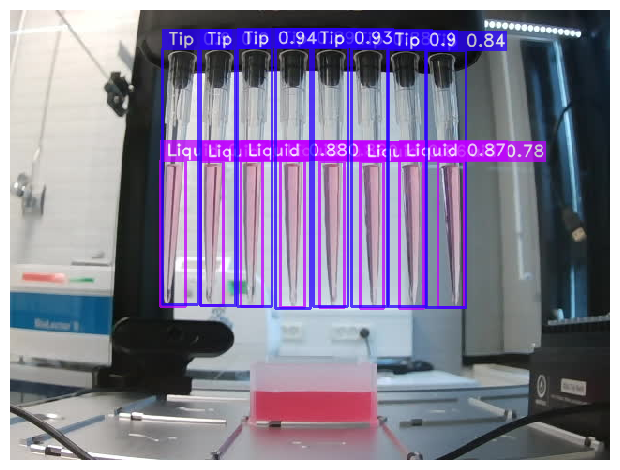

Predicting Images: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
c:\Users\thisi\anaconda3\envs\OT2\lib\site-packages\super_gradients\training\utils\visualization\utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


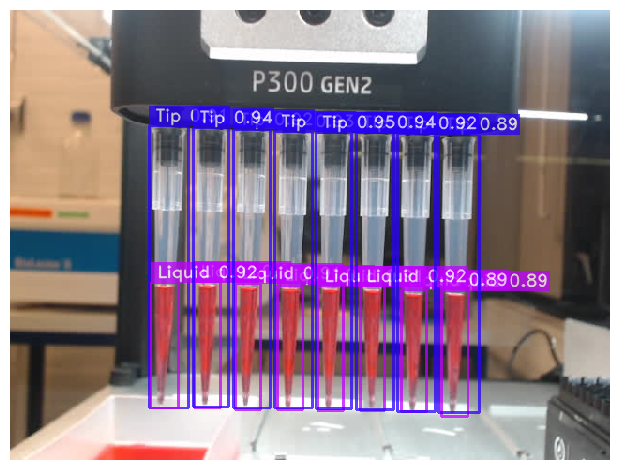

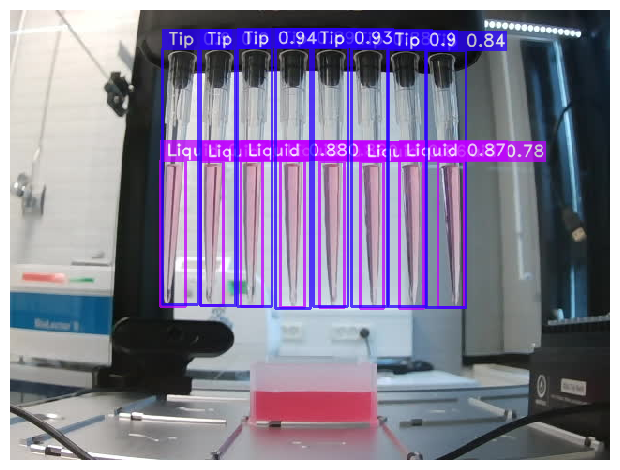

In [18]:
Images = [r"D:\Final Project\Yolo nas\Dataset\test\images\tipsWaterRed_13.jpg",
          r"D:\Final Project\Yolo nas\Dataset\test\images\AI__H60_95ul_nr3.jpg",
          r"D:\Final Project\Yolo nas\Dataset\test\images\tipsWaterRed_13.jpg"]


images_predications = best_model.predict(Images, iou=0.5, conf=0.4).show()

c:\Users\thisi\anaconda3\envs\OT2\lib\site-packages\super_gradients\training\utils\media\image.py:64: UserWarning: It seems you are using predict() with batch input
  warnings.warn("It seems you are using predict() with batch input")
Predicting Images:   0%|          | 0/4 [00:00<?, ?it/s][2024-01-20 21:45:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


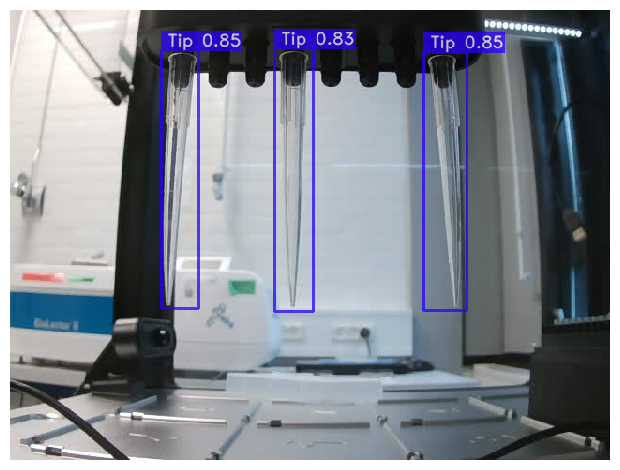

Predicting Images: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]
c:\Users\thisi\anaconda3\envs\OT2\lib\site-packages\super_gradients\training\utils\visualization\utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


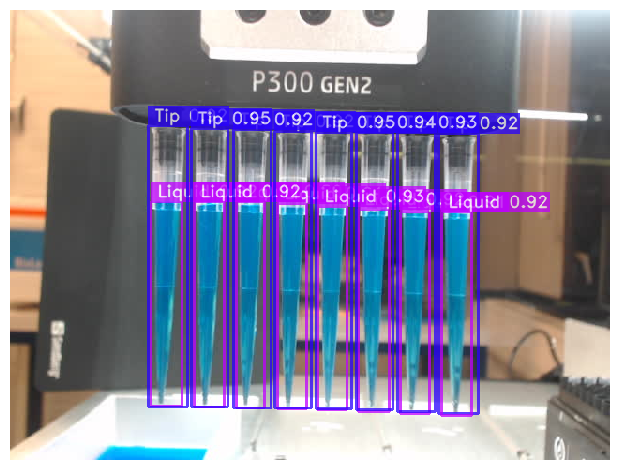

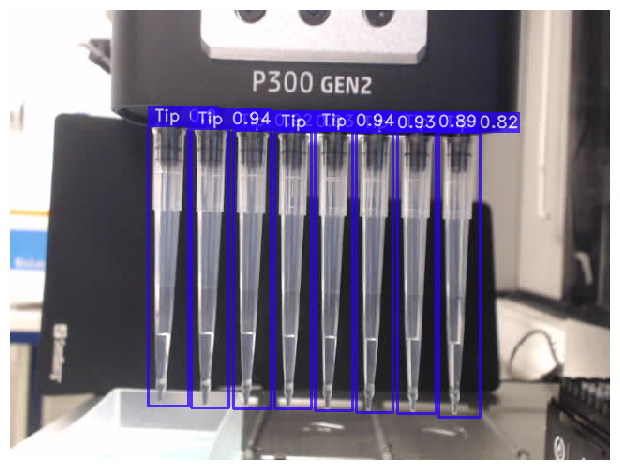

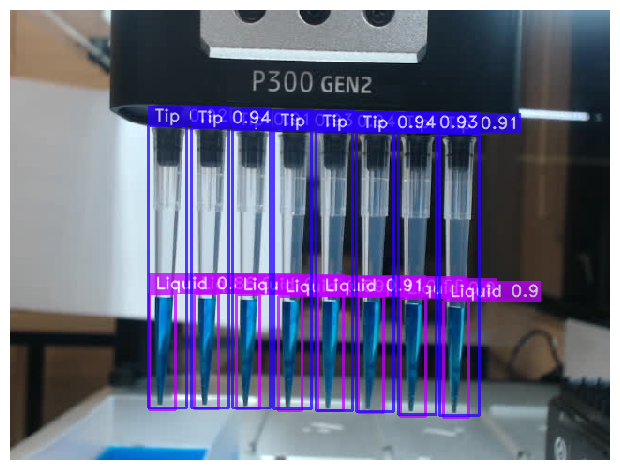

In [21]:
Images = [r"D:\Final Project\Yolo nas\Dataset\test\images\DeckImage_test.jpg",
          r"D:\Final Project\Yolo nas\Dataset\valid\images\AI__H60__Blue17_275ul_nr17.jpg",
          r"D:\Final Project\Yolo nas\Dataset\valid\images\AI__H60__light blue1_35ul_nr1.jpg",
          r"D:\Final Project\Yolo nas\Dataset\valid\images\AI__H60__Blue4_80ul_nr4.jpg"]


images_predications = best_model.predict(Images, iou=0.5, conf=0.8).show()

In [23]:
import torch
device = 0 if torch.cuda.is_available() else "cpu"

input_video_path = r"D:\Final Project\Yolo nas\Dataset\OT2_8.mp4"
output_video_path = "detections_one_80.mp4"
# device=0

best_model.to(device).predict(input_video_path,iou=0.5, conf=0.8).save(output_video_path)

Processing Video: 100%|█████████▉| 3615/3632 [03:22<00:00, 30.30it/s]

Processing Video: 100%|██████████| 3632/3632 [03:23<00:00, 17.84it/s]
